In [1]:
import os
from contextlib import nullcontext

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from model.transformer import ModelArgs, Transformer
from util.prepare_data import BatteryData

torch.manual_seed(422)
np.random.seed(422)

In [2]:
def check_in_out(x, y, y_hat, y_hat_pseudo, file_path=None, dataset_name=None, ckpt_path=None):
    with h5py.File(file_path, "r") as file:
        data_scaled = file[dataset_name]
        mins, maxs = data_scaled.attrs["min_values"], data_scaled.attrs["max_values"]
    fig = plt.figure(dpi=300)
    ax = fig.subplots(3, 1, sharex=True)

    batch_nr = 0
    for i in range(x.shape[-1]):
        x[:, :, i] = x[:, :, i] * (maxs[i] - mins[i]) + mins[i]
        ax[0].plot(x[batch_nr, :, i], label="X")
    # ax[0].legend()

    for i in [0]:
        y[:, :, i] = y[:, :, i] * (maxs[i + 3] - mins[i + 3]) + mins[i + 3]
        y_hat[:, :, i] = y_hat[:, :, i] * (maxs[i + 3] - mins[i + 3]) + mins[i + 3]
        y_hat_pseudo[:, :, i] = (
            y_hat_pseudo[:, :, i] * (maxs[i + 3] - mins[i + 3]) + mins[i + 3]
        )

        ax[1].plot(y[batch_nr, :, i], label="Y")
        ax[1].plot(y_hat[batch_nr, :, i], "--", label="y_hat")
        ax[1].plot(y_hat_pseudo[batch_nr, :, i], ":", label="y_hat_pseudo")

    for i in [1]:
        y[:, :, i] = y[:, :, i] * (maxs[i + 3] - mins[i + 3]) + mins[i + 3]
        y_hat[:, :, i] = y_hat[:, :, i] * (maxs[i + 3] - mins[i + 3]) + mins[i + 3]
        y_hat_pseudo[:, :, i] = (
            y_hat_pseudo[:, :, i] * (maxs[i + 3] - mins[i + 3]) + mins[i + 3]
        )

        ax[2].plot(y[batch_nr, :, i], label="Y")
        ax[2].plot(y_hat[batch_nr, :, i], "--", label="y_hat")
        ax[2].plot(y_hat_pseudo[batch_nr, :, i], ":", label="y_hat_pseudo")

    #for i in [1, 3]:
    # for i in [1, 3]:
    #     y[:, :, i] = y[:, :, i] * (maxs[i + 1] - mins[i + 1]) + mins[i + 1]
    #     y_hat[:, :, i] = y_hat[:, :, i] * (maxs[i + 1] - mins[i + 1]) + mins[i + 1]
    #     y_hat_pseudo[:, :, i] = (
    #         y_hat_pseudo[:, :, i] * (maxs[i + 1] - mins[i + 1]) + mins[i + 1]
    #     )

    #     ax[3].plot(y[batch_nr, :, i], label="Y")
    #     ax[3].plot(y_hat[batch_nr, :, i], "--", label="y_hat")
    #     ax[3].plot(y_hat_pseudo[batch_nr, :, i], ":", label="y_hat_pseudo")
    
    
    # ax[1].legend()
    # ax[2].legend()
    plt.tight_layout()
    fig.savefig(ckpt_path.replace(".pt", ".png"), dpi=300)
    plt.show()
    


@torch.no_grad()
def estimate_loss(ckpt_path, model_args):
    torch.cuda.empty_cache()
    torch.manual_seed(422)
    np.random.seed(422)

    data_file = os.path.abspath("data/train/battery_data.h5")
    dataset = "spme_training_scaled"
    batch_size = 1  # if gradient_accumulation_steps > 1, this is the micro-batch size
    device = "cuda"
    
    print(f"Resuming training from {ckpt_path}")
    # resume training from a checkpoint.
    checkpoint = torch.load(ckpt_path, map_location=device)
    checkpoint_model_args = checkpoint["model_args"]
    # force these config attributes to be equal otherwise we can't even resume training
    # the rest of the attributes (e.g. dropout) can stay as desired from command line
    for k in ["n_layer", "n_heads", "dim_model", "seq_len", "bias"]:
        model_args.__setattr__(k, checkpoint_model_args.__getattribute__(k))
    # create the model
    model_args.max_seq_len = model_args.seq_len
    seq_len = model_args.seq_len
    model = Transformer(model_args)
    state_dict = checkpoint["model"]
    # fix the keys of the state dictionary :(
    # honestly no idea how checkpoints sometimes get this prefix, have to debug more
    unwanted_prefix = "_orig_mod."
    for k, v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix) :]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
    iter_num = checkpoint["iter_num"]
    best_val_loss = checkpoint["best_val_loss"]
    model.to(device)
    
    train_data = BatteryData(data_file, dataset, batch_size, seq_len, device)
    
    dtype = (
        "bfloat16"
        if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
        else "float16"
    )
    
    device_type = (
        "cuda" if "cuda" in device else "cpu"
    )  # for later use in torch.autocast
    ptdtype = {
        "float32": torch.float32,
        "bfloat16": torch.bfloat16,
        "float16": torch.float16,
    }[dtype]
    ctx = (
        nullcontext()
        if device_type == "cpu"
        else torch.autocast(device_type=device_type, dtype=ptdtype)
    )

    
    model.eval()
    X, Y = train_data.get_batch(split="pred")
    y_hat = []
    y_hat_pseudo = []
    with torch.no_grad():
        with ctx:
            input = X[:, :seq_len]
            input_pseudo = X[:, :seq_len]
            for i in range(seq_len*5): #############################################change
                y, _ = model(input)
                y_hat.append(y.to(torch.float32).cpu().numpy())
                input = torch.roll(input, -1, 1)
                input[:, -1, :3] = X[:, seq_len + i, :3]
                # input[:, -1, 1:] = y[:, -1, 1:] if y.shape[-1]==6 else y[:, -1]
                input[:, -1, 3:] = y[:, -1, 1:] if y.shape[-1]==6 else y[:, -1]
    
                y, _ = model(input_pseudo)
                y_hat_pseudo.append(y.to(torch.float32).cpu().numpy())
                input_pseudo = torch.roll(input_pseudo, -1, 1)
                input_pseudo[:, -1, :3] = X[:, seq_len + i, :3]
                # input_pseudo[:, -1, 3:] = y[:, -1, (2+1):] if y.shape[-1]==6 else y[:, -1, 2:]
                input[:, -1, 3:] = y[:, -1, 1:] if y.shape[-1]==6 else y[:, -1]
    
            y_hat = np.concatenate(y_hat, axis=1)
            y_hat_pseudo = np.concatenate(y_hat_pseudo, axis=1)
            loss = np.mean(np.sum(Y[:, seq_len:].to(torch.float32).cpu().numpy() - y_hat) ** 2)
            loss_pseudo = np.mean(np.sum(Y[:, seq_len:].to(torch.float32).cpu().numpy() - y_hat_pseudo) ** 2)
            print(loss, loss_pseudo)
            check_in_out(
                X[:, seq_len:].to(torch.float32).cpu().numpy(),
                Y[:, seq_len:,1:].to(torch.float32).cpu().numpy() if y.shape[-1]==6 else Y[:, seq_len:].to(torch.float32).cpu().numpy(),
                y_hat[:,:,1:] if y.shape[-1]==6 else y_hat,
                y_hat_pseudo[:,:,1:] if y.shape[-1]==6 else y_hat_pseudo,
                file_path=data_file,
                dataset_name=dataset,
                ckpt_path=ckpt_path
            )


Resuming training from ckpt/transformer/v_8/7.8e-06_val_loss.pt
number of parameters: 113.26M
5460750.852419436 407207.25464725494


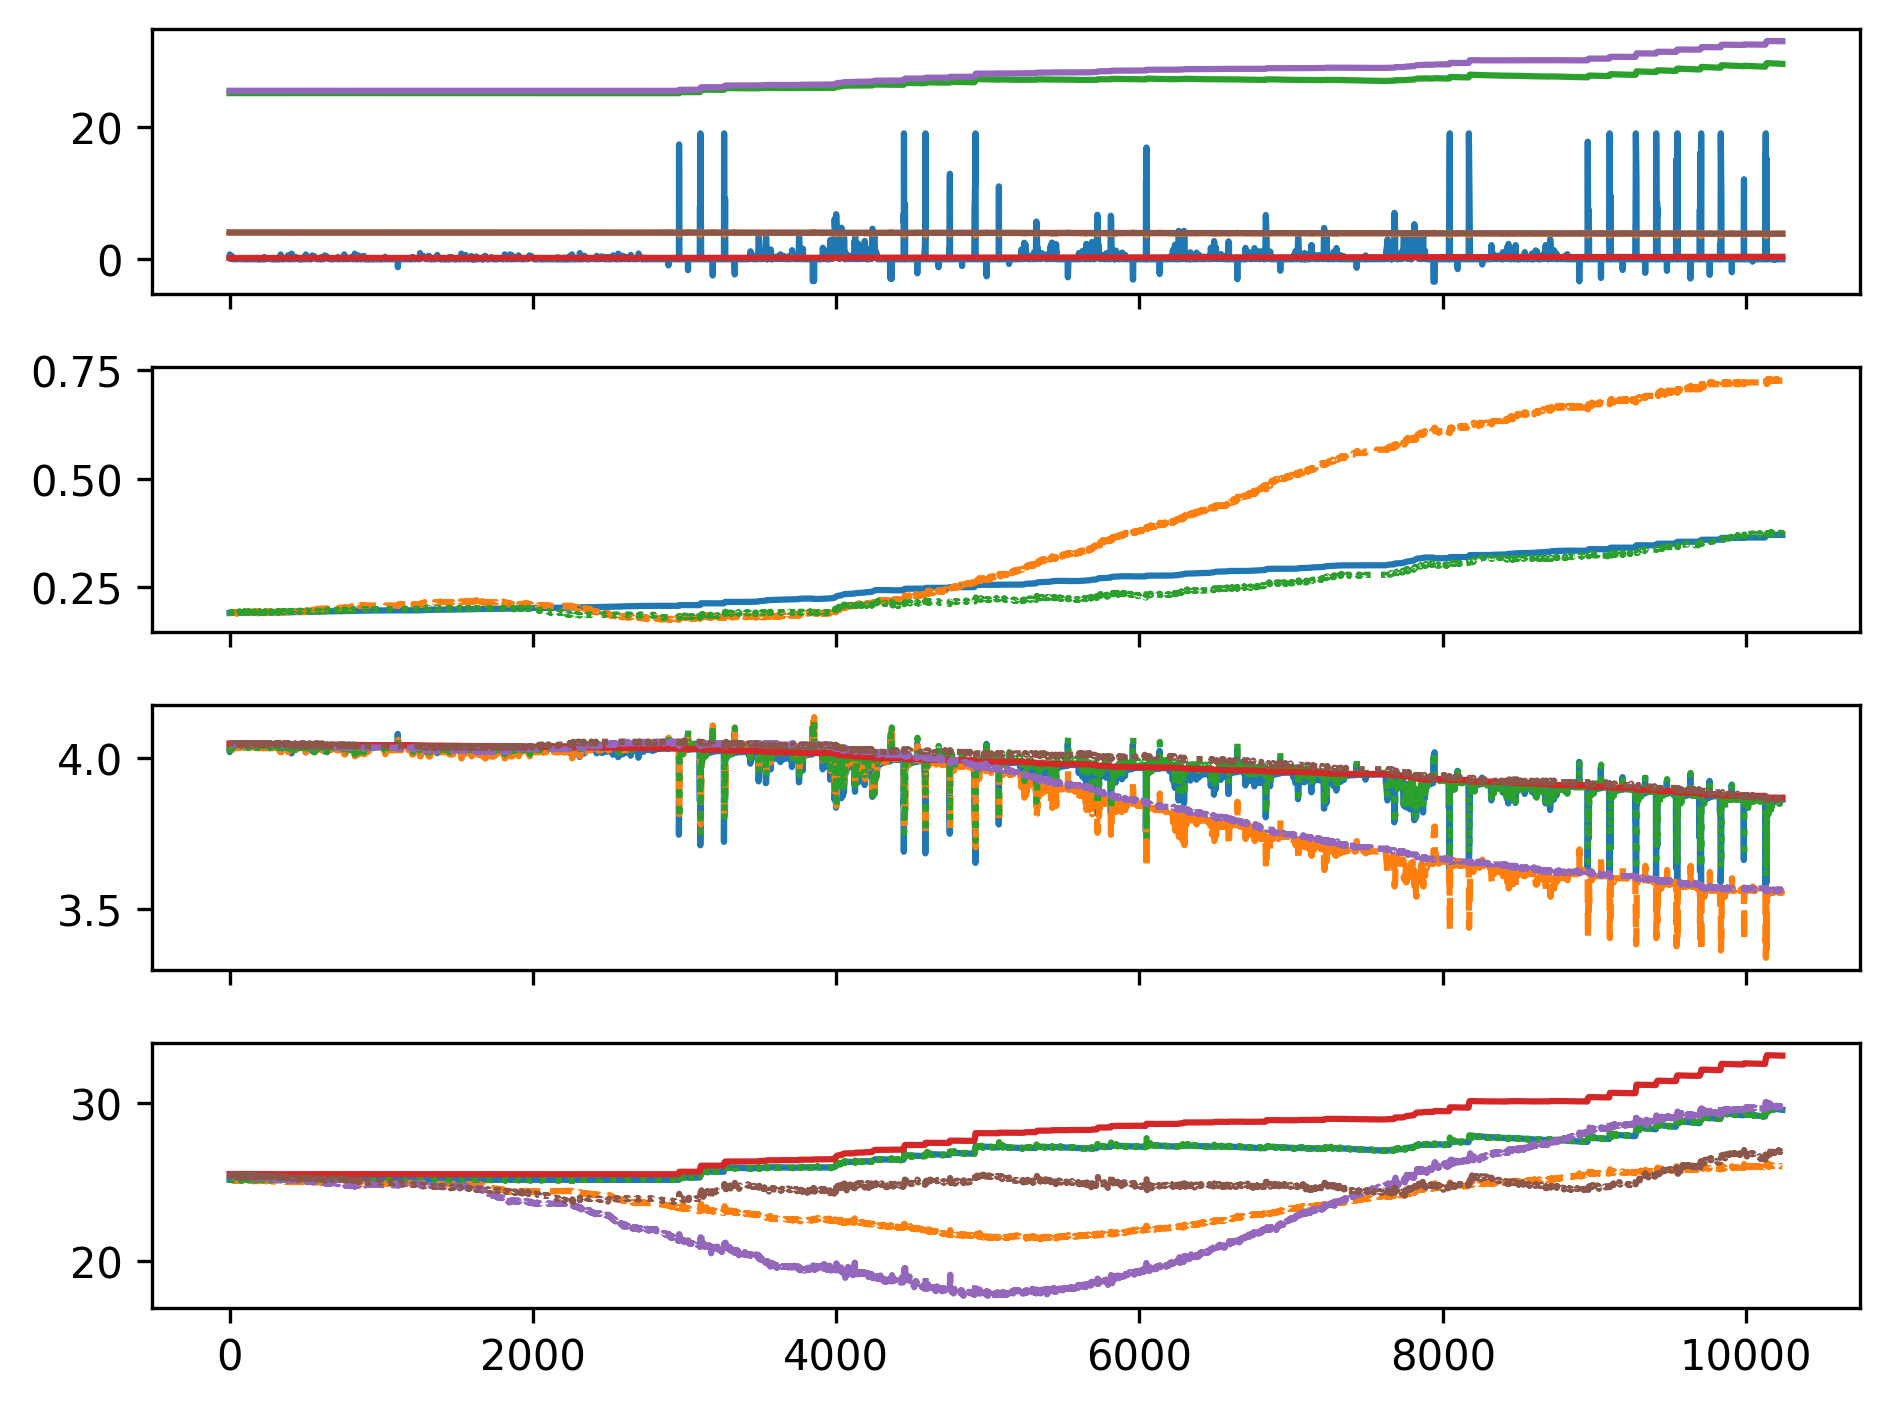

In [3]:
# MSE and LR scheduler on grad norm
ckpt_path = "ckpt/transformer/v_8/7.8e-06_val_loss.pt"
model_args = ModelArgs()
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_4/5.3e-05_val_loss.pt
number of parameters: 113.26M
44086280.0625 9844678.384281158


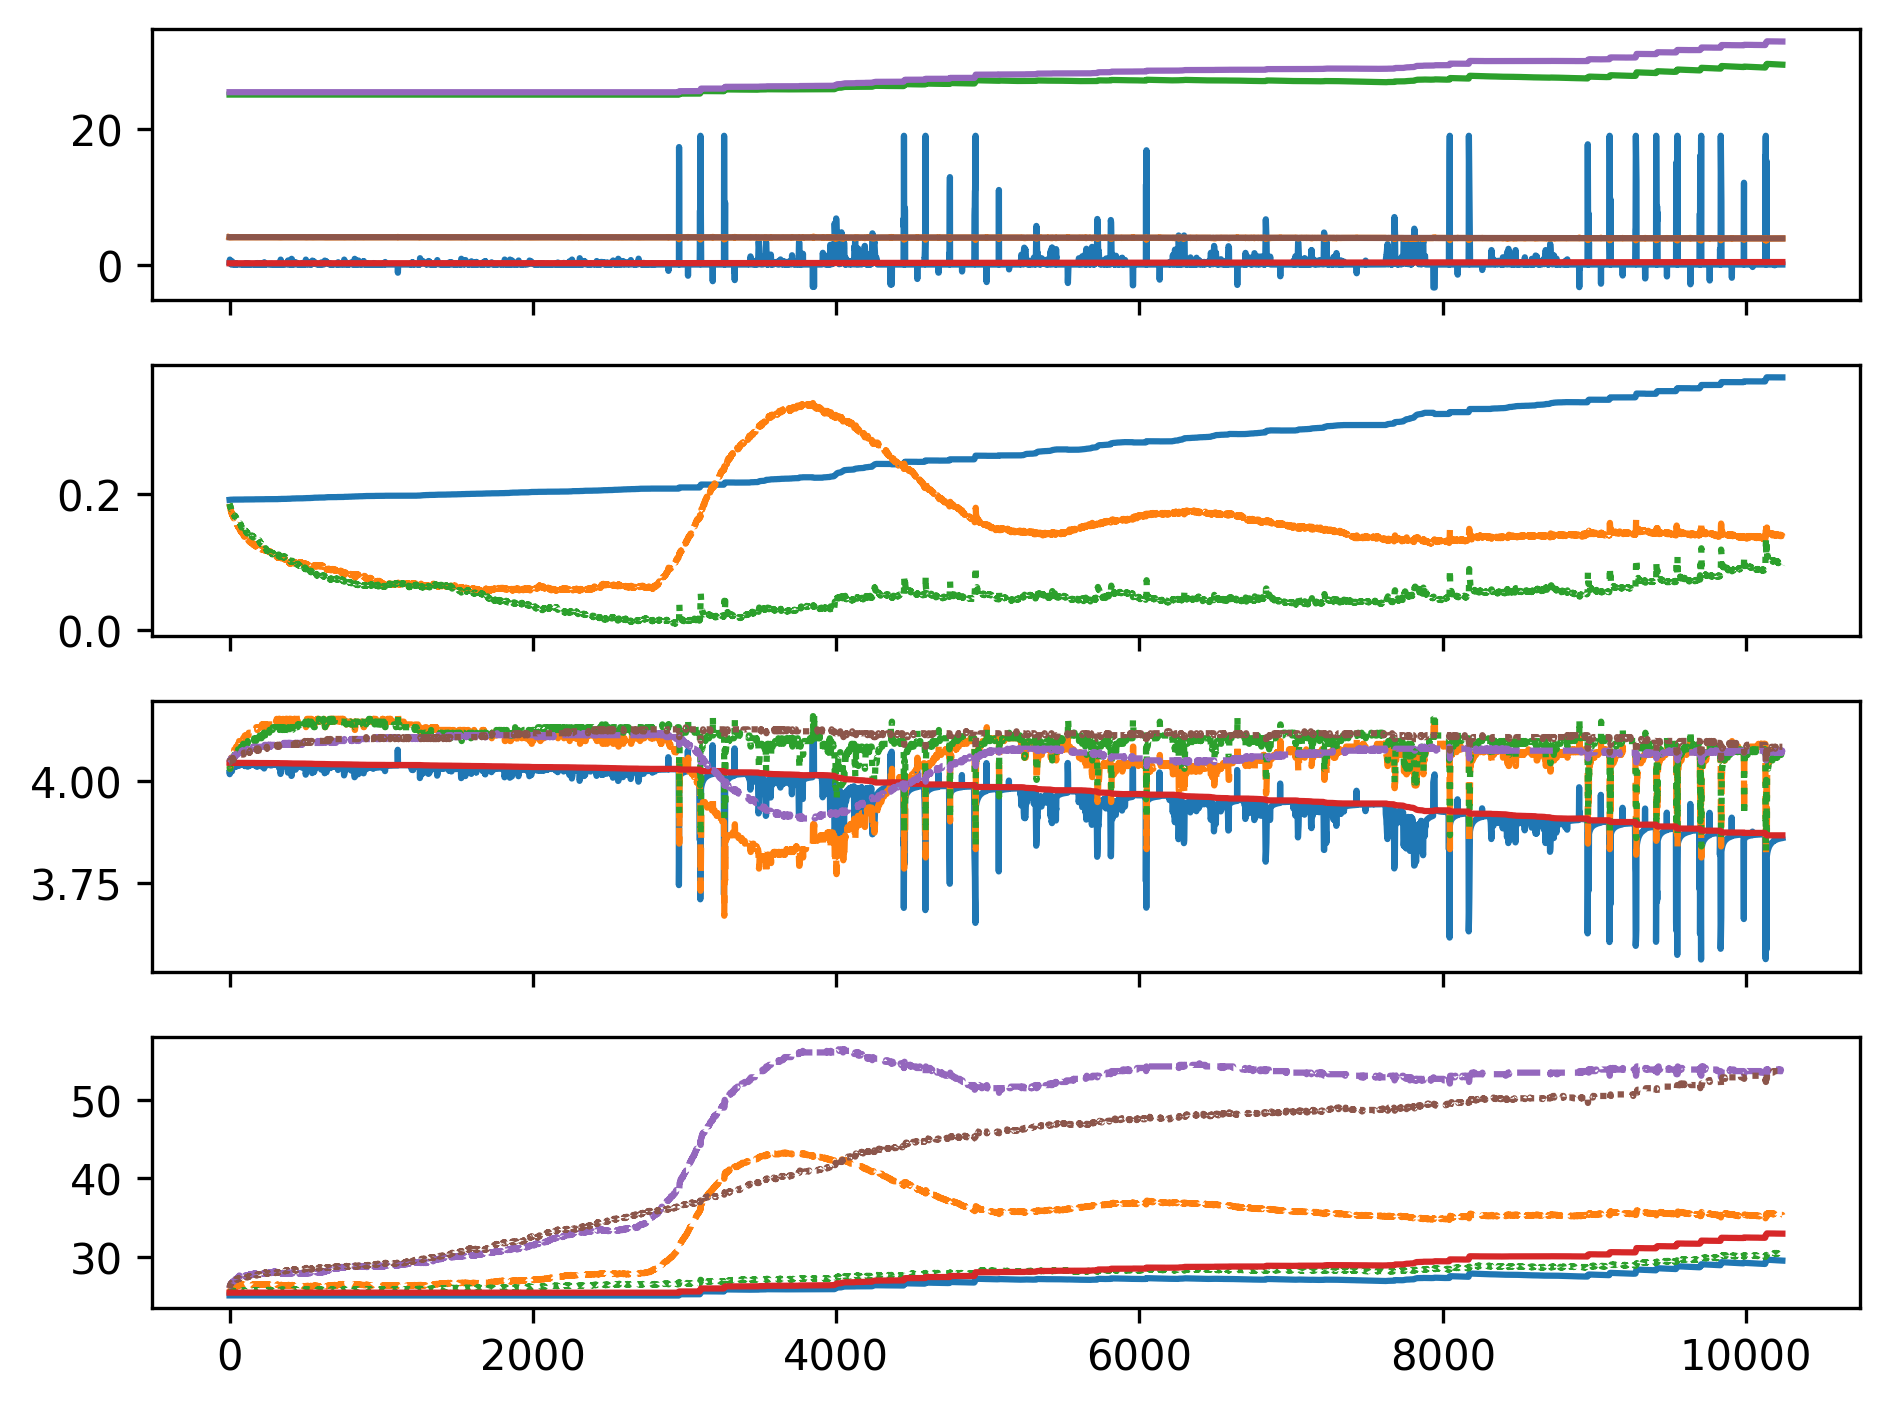

In [4]:
# MSE Sum
ckpt_path = "ckpt/transformer/v_4/5.3e-05_val_loss.pt"
model_args = ModelArgs()
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_1/1.9e-02_val_loss.pt
number of parameters: 113.26M
5732.781466210494 1184994.8927881718


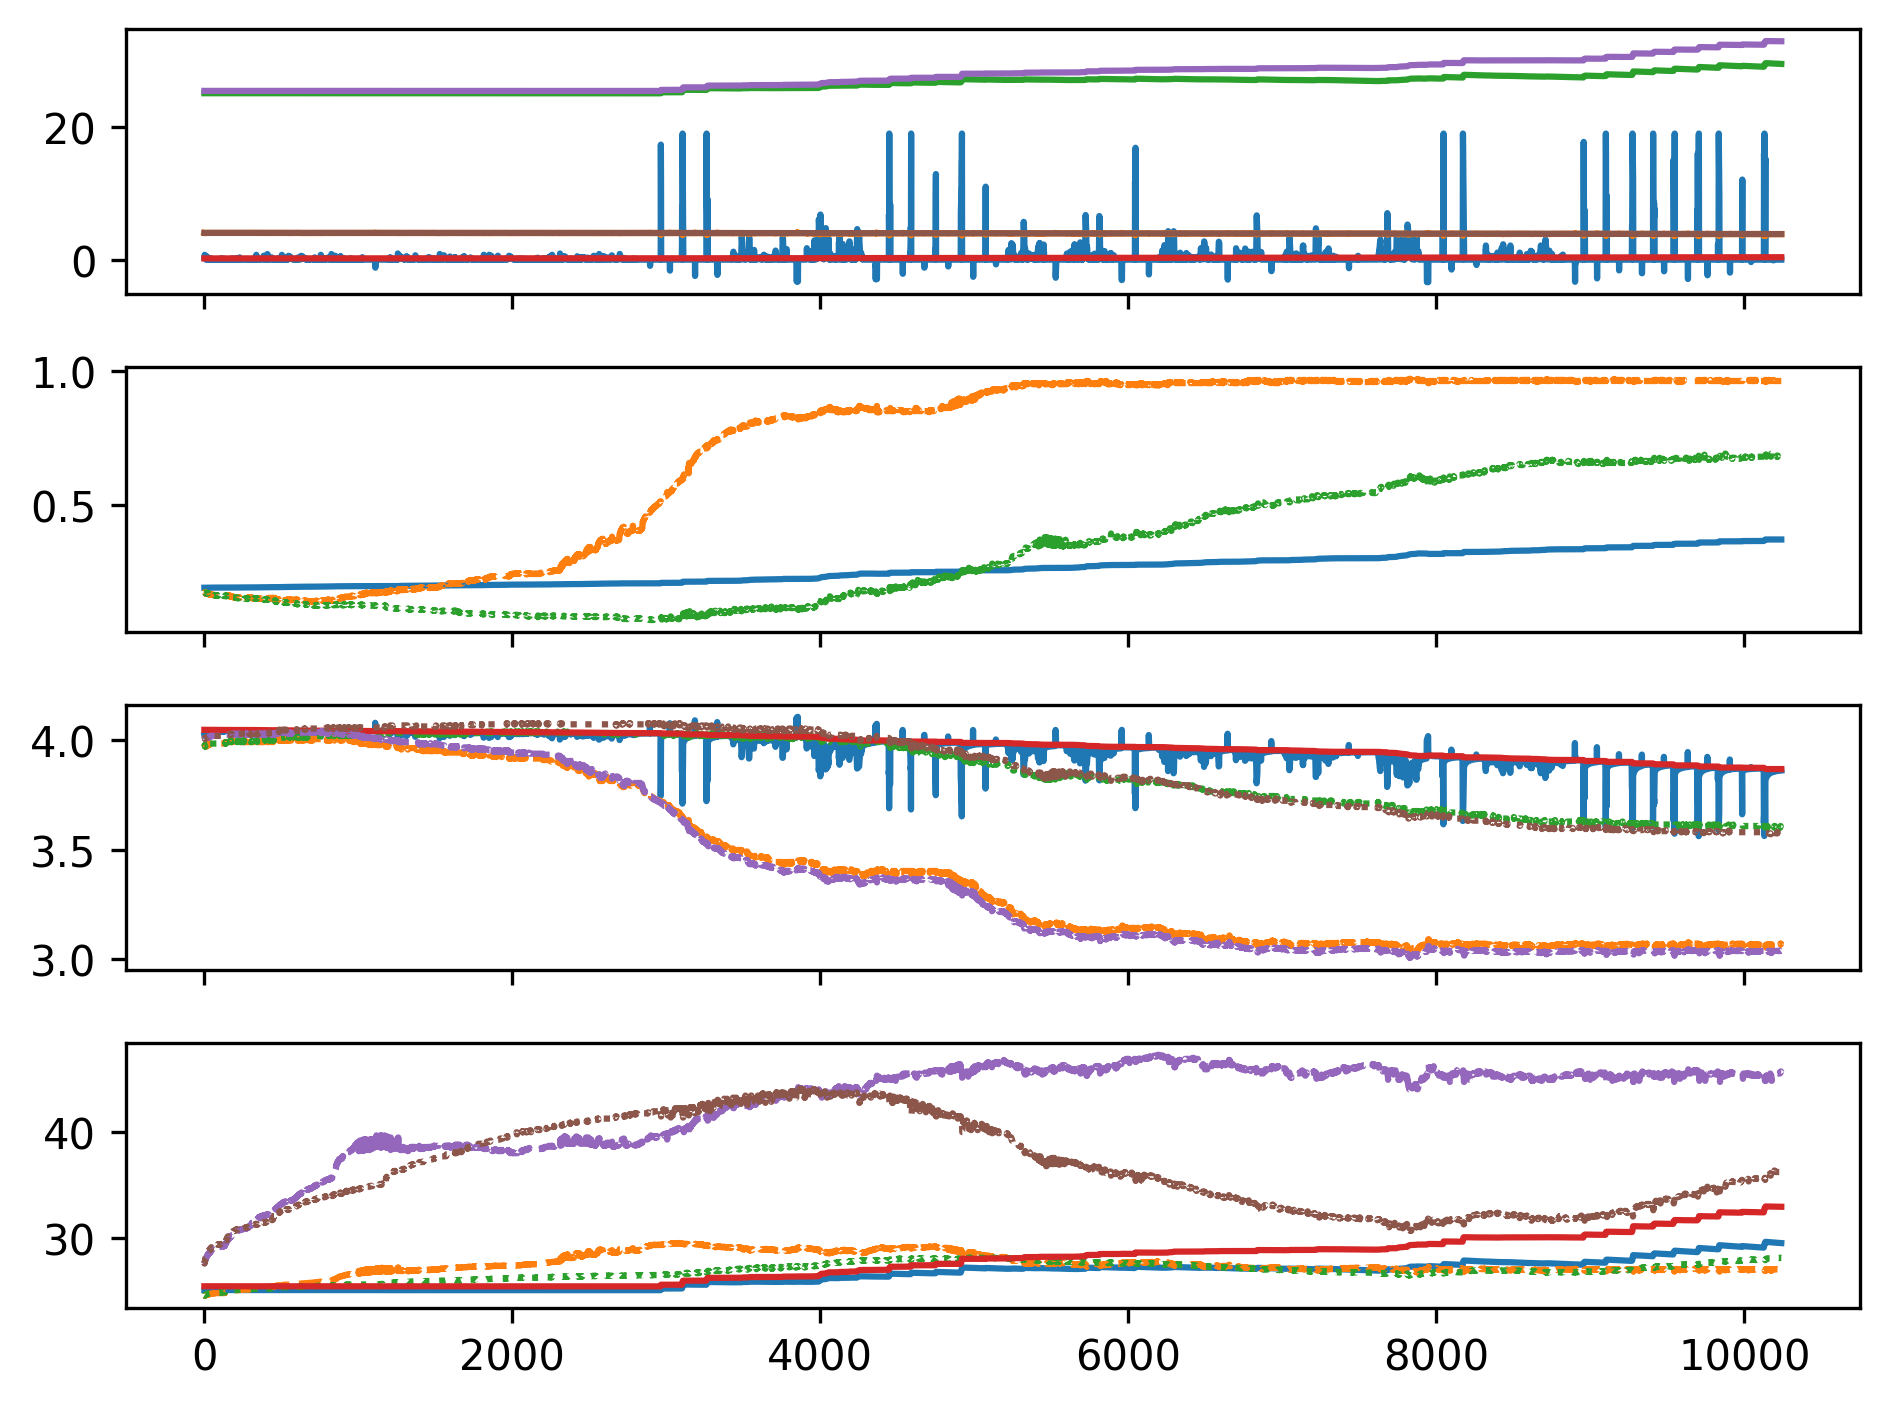

In [5]:
# MAE
ckpt_path = "ckpt/transformer/v_1/1.9e-02_val_loss.pt"
model_args = ModelArgs()
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_10/1.3e-04_val_loss.pt
number of parameters: 113.39M
29091.45709810988 871.5416891242057


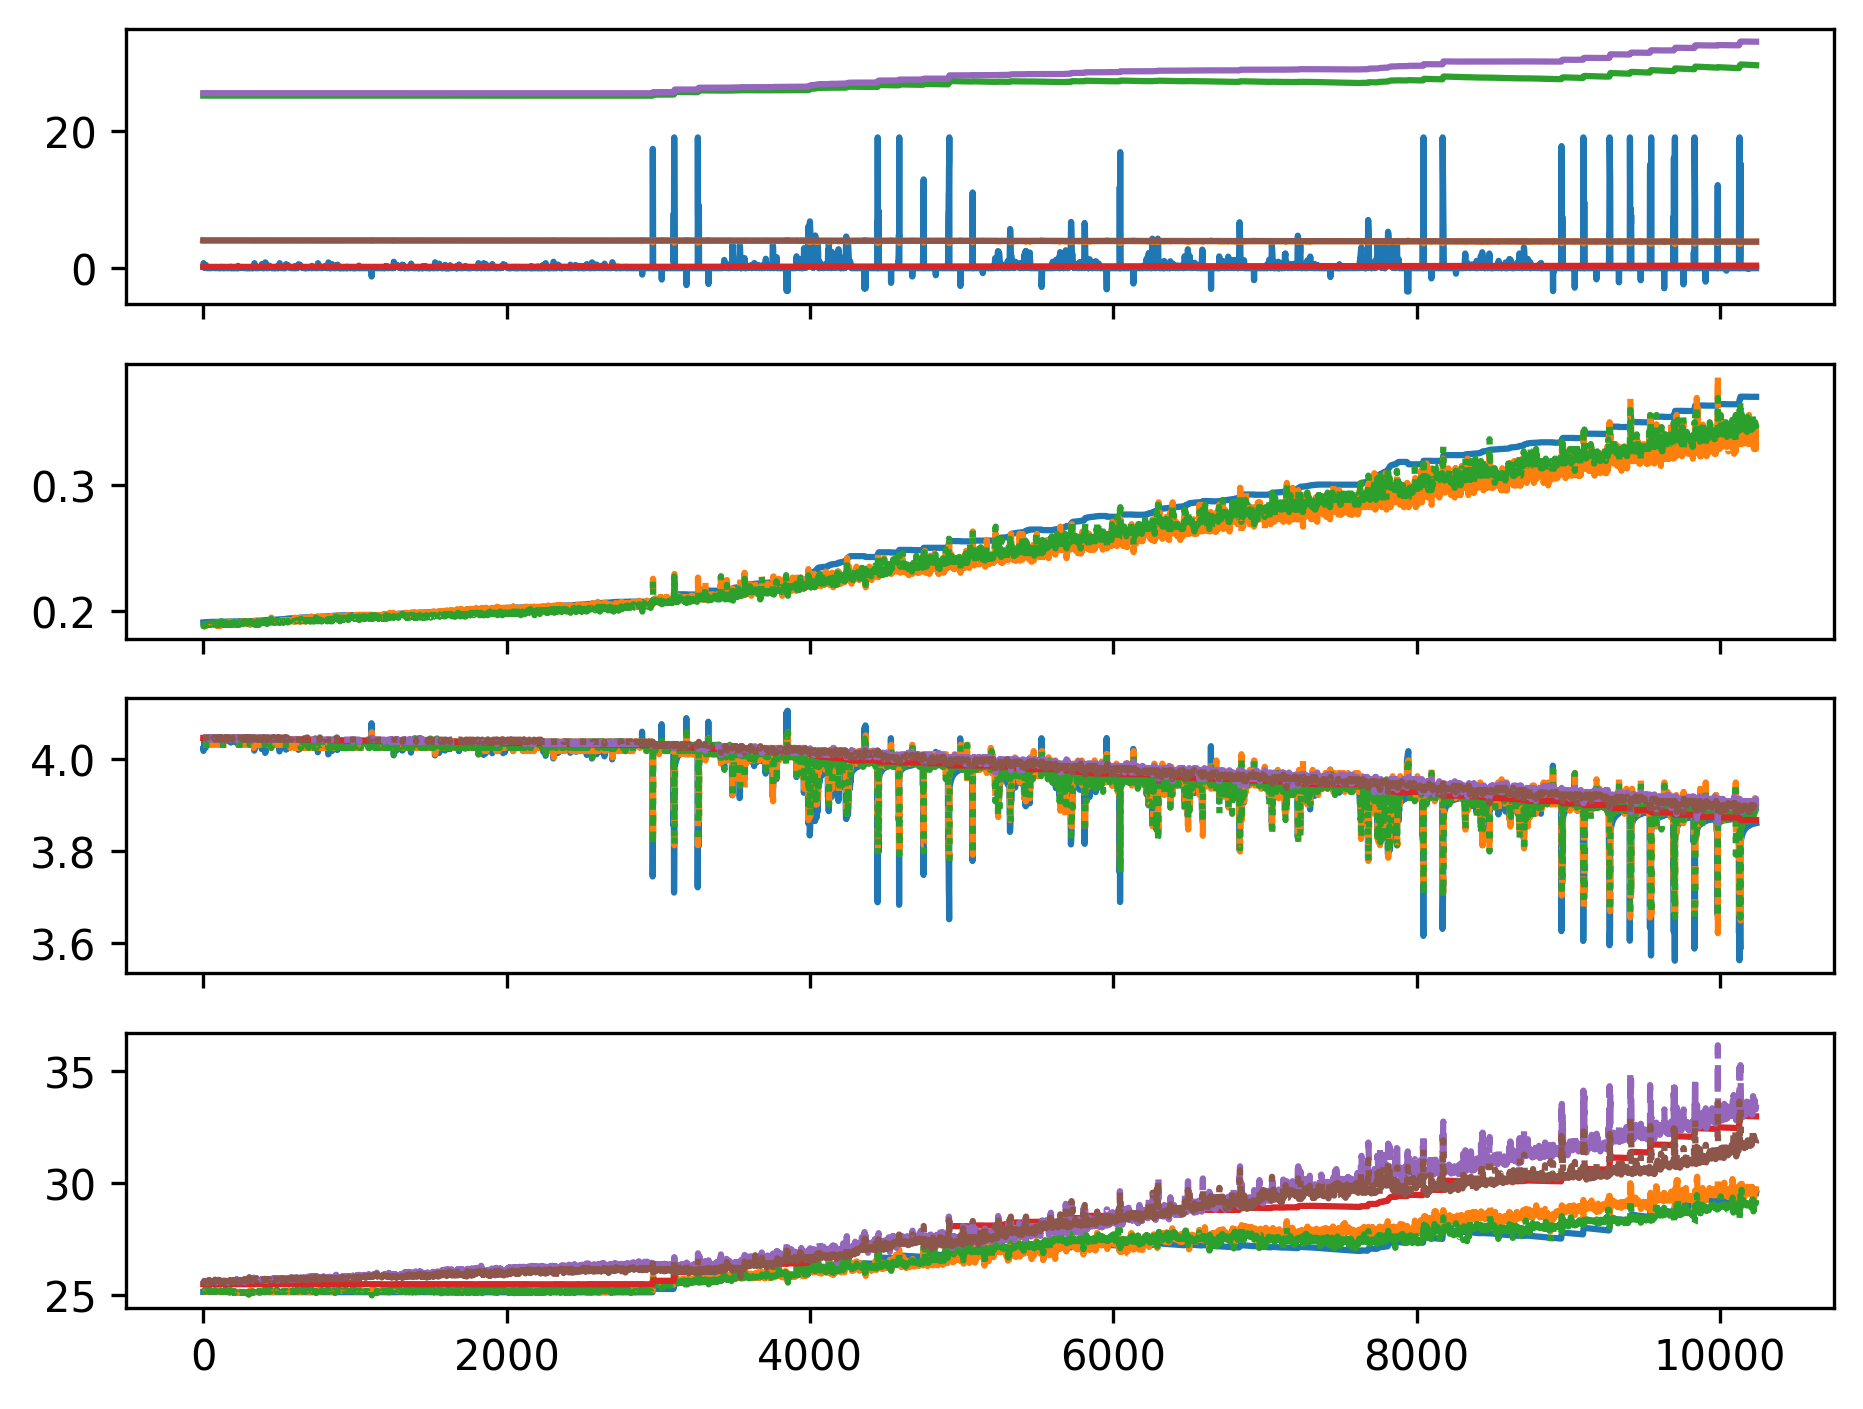

In [3]:
# transformer_trapz_bias_6out_abspe
####### CHANGE y in get batch
ckpt_path = "ckpt/transformer/v_10/1.3e-04_val_loss.pt"
model_args = ModelArgs(pe_type = "abs", dim_out = 6, bias=True)
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_9/6.4e-05_val_loss.pt
number of parameters: 113.39M
365478.4000182748 25818.182635540375


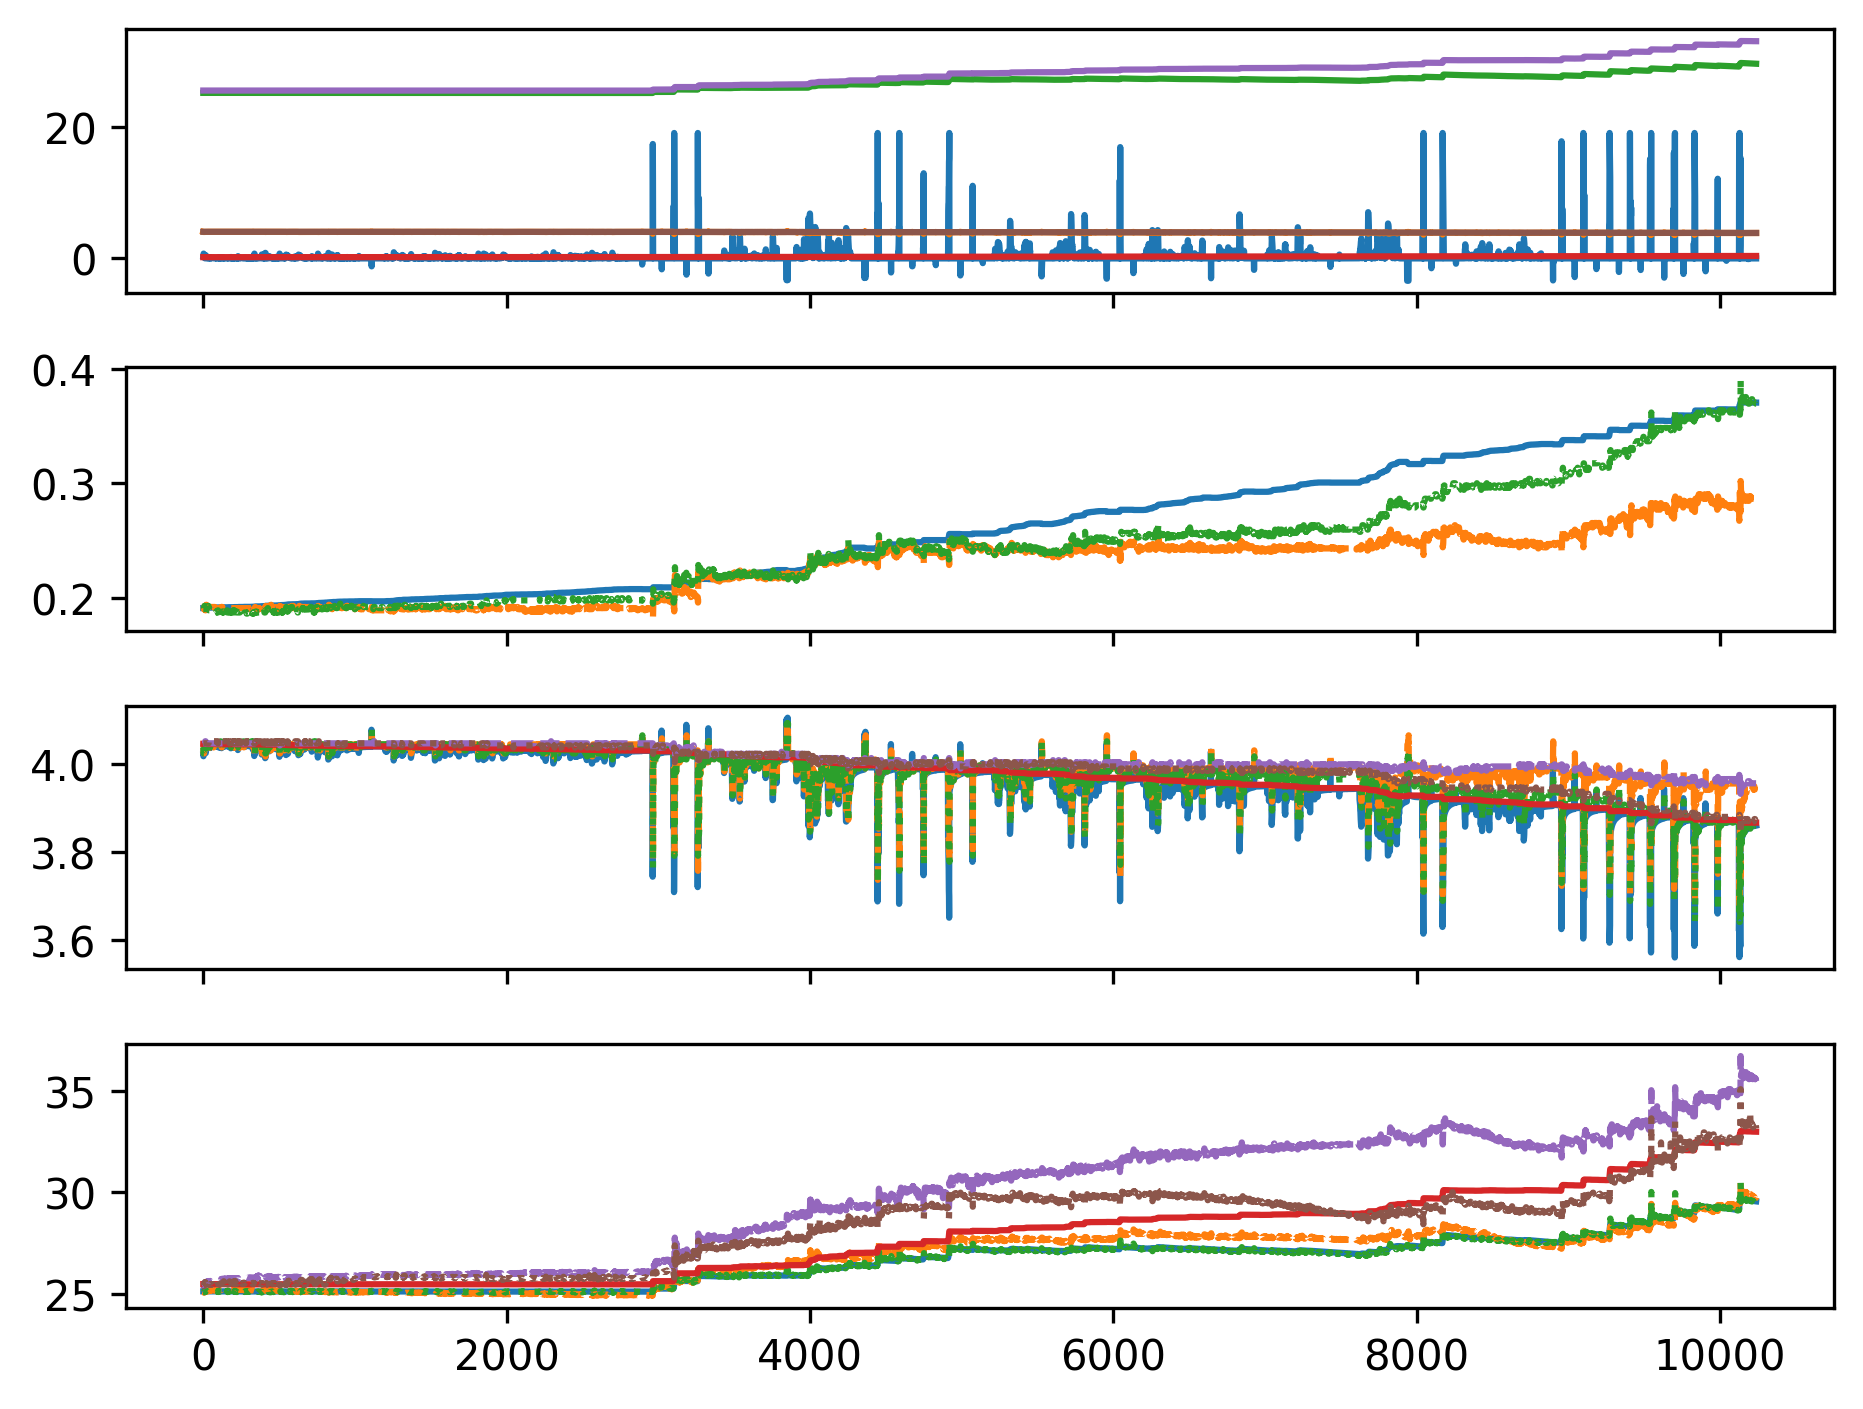

In [4]:
# transformer_trapz_bias_6out
####### CHANGE y in get batch
ckpt_path = "ckpt/transformer/v_9/6.4e-05_val_loss.pt"
model_args = ModelArgs(dim_out = 6, bias=True)
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_12/9.4e-06_val_loss.pt
number of parameters: 113.39M
450180.79876542464 340261.51888454333


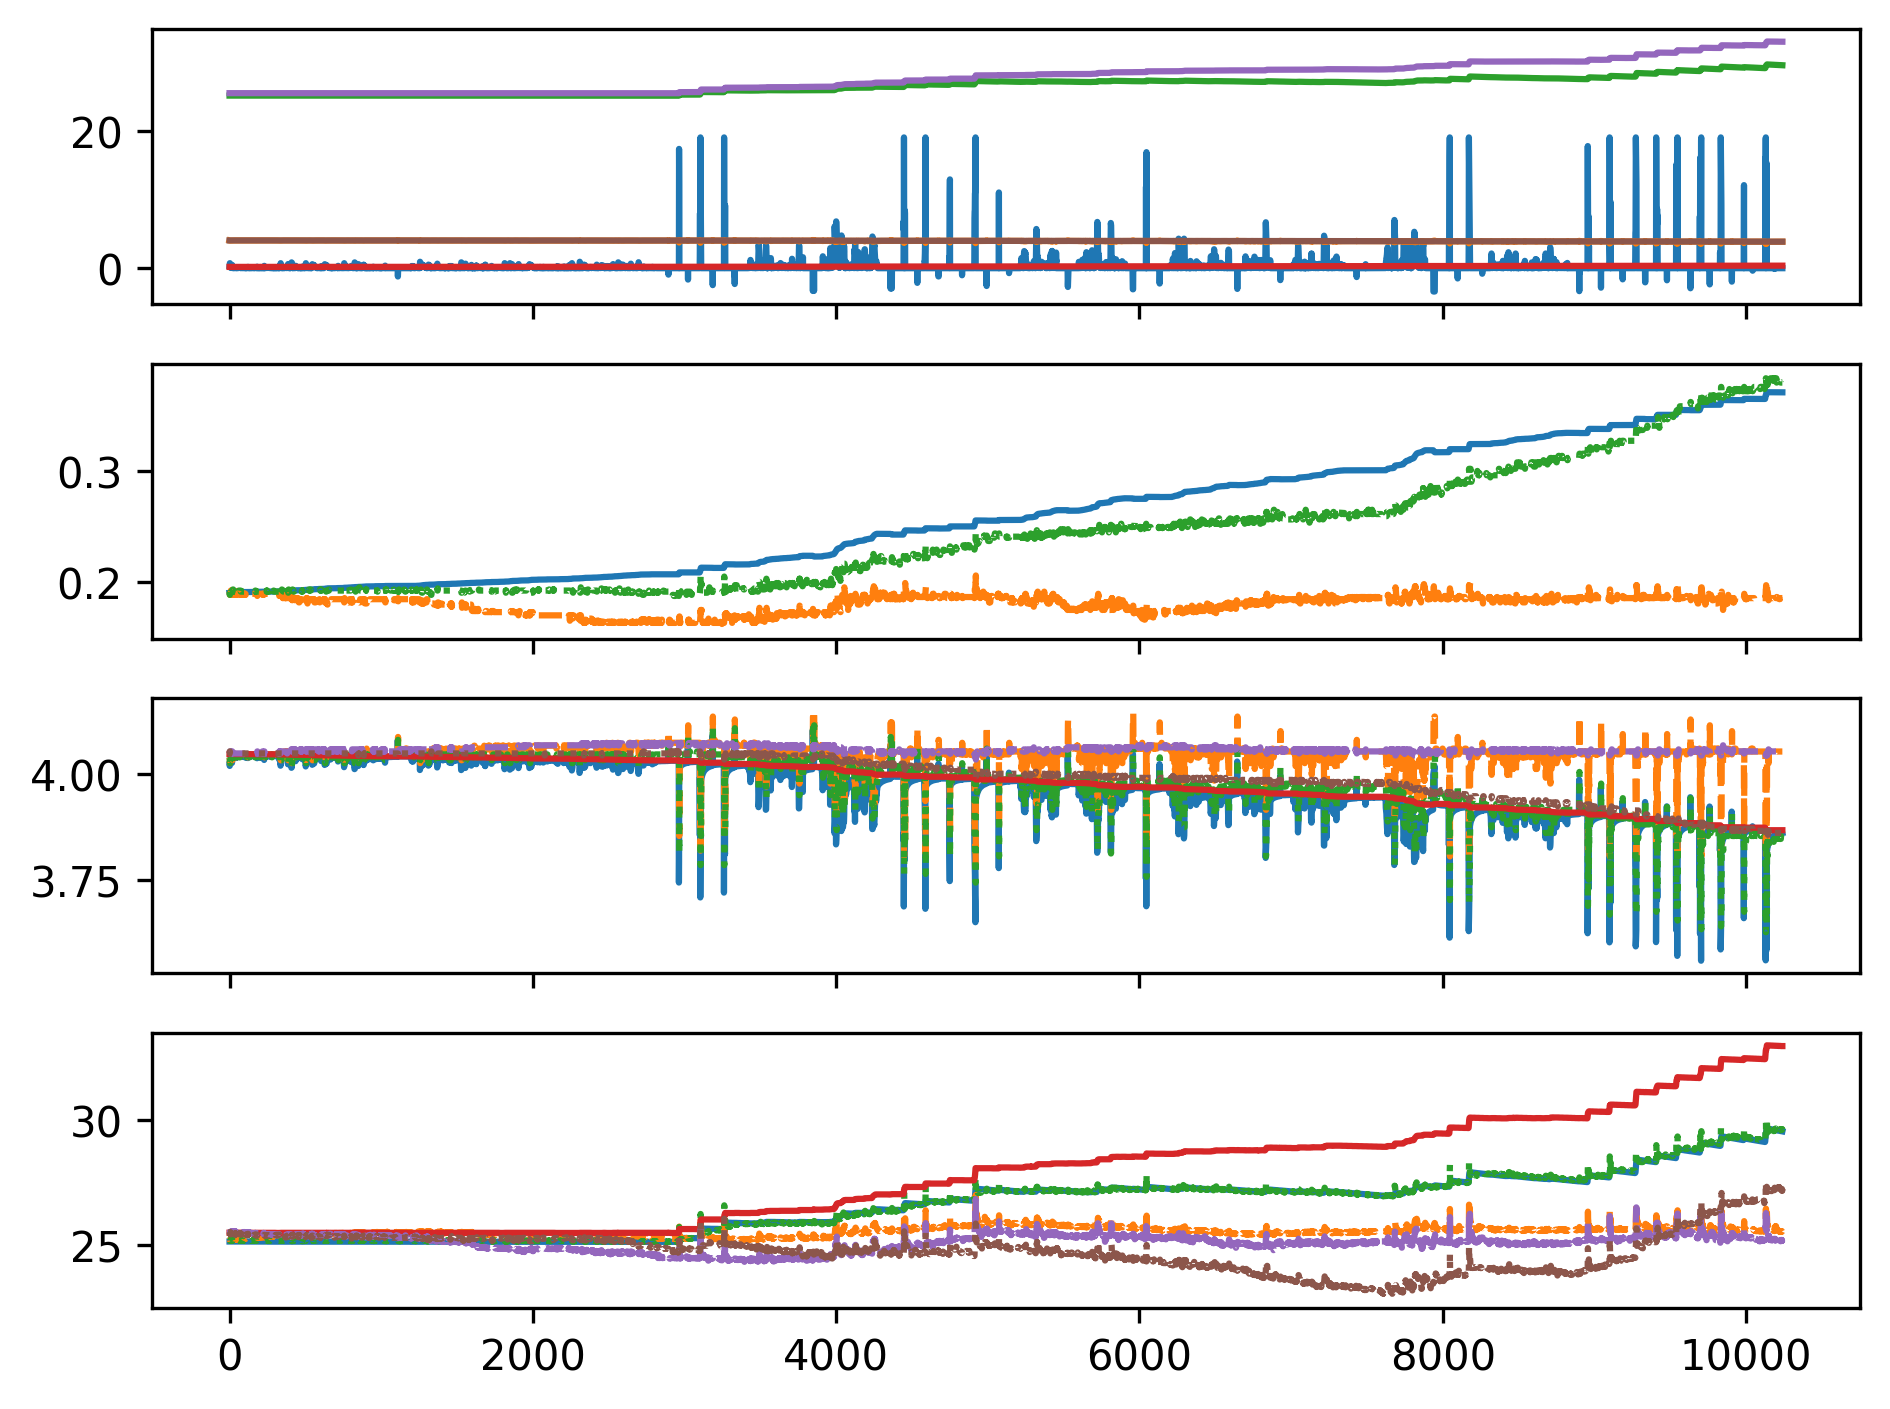

In [3]:
# transformer_trapz_bias
ckpt_path = "ckpt/transformer/v_12/9.4e-06_val_loss.pt"
model_args = ModelArgs(pe_type = "RoPE", bias = True)
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_14/4.4e-05_val_loss.pt
number of parameters: 113.26M
465862.5712824464 51.370882869914794


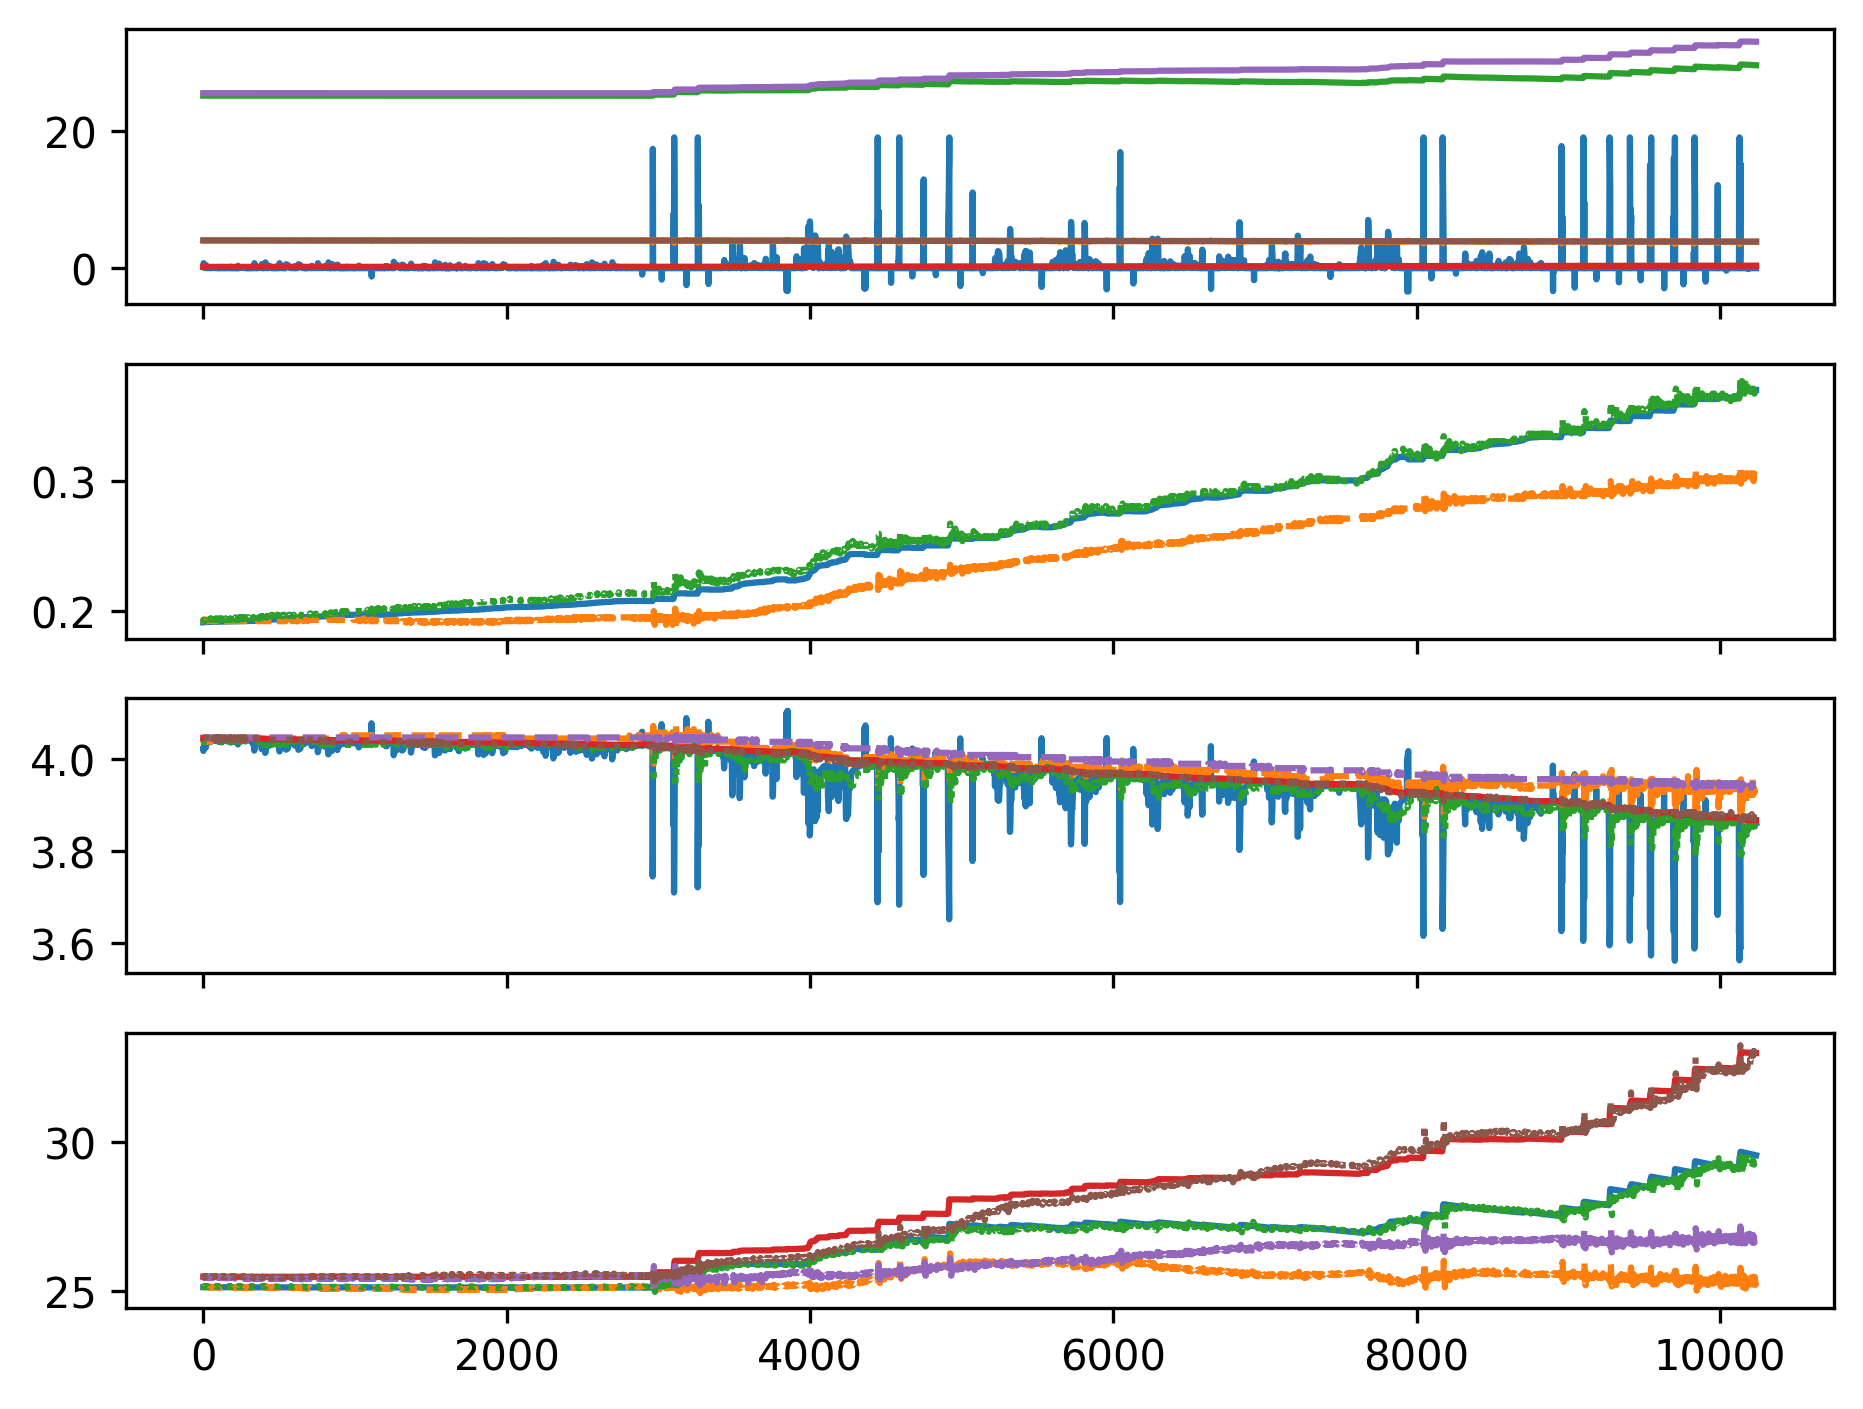

In [3]:
# transformer_trapz_2_abspe
ckpt_path = "ckpt/transformer/v_14/4.4e-05_val_loss.pt"
model_args = ModelArgs(pe_type = "abs")
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_15/1.3e-05_val_loss.pt
number of parameters: 113.26M
985237.627061788 90186.02131578699


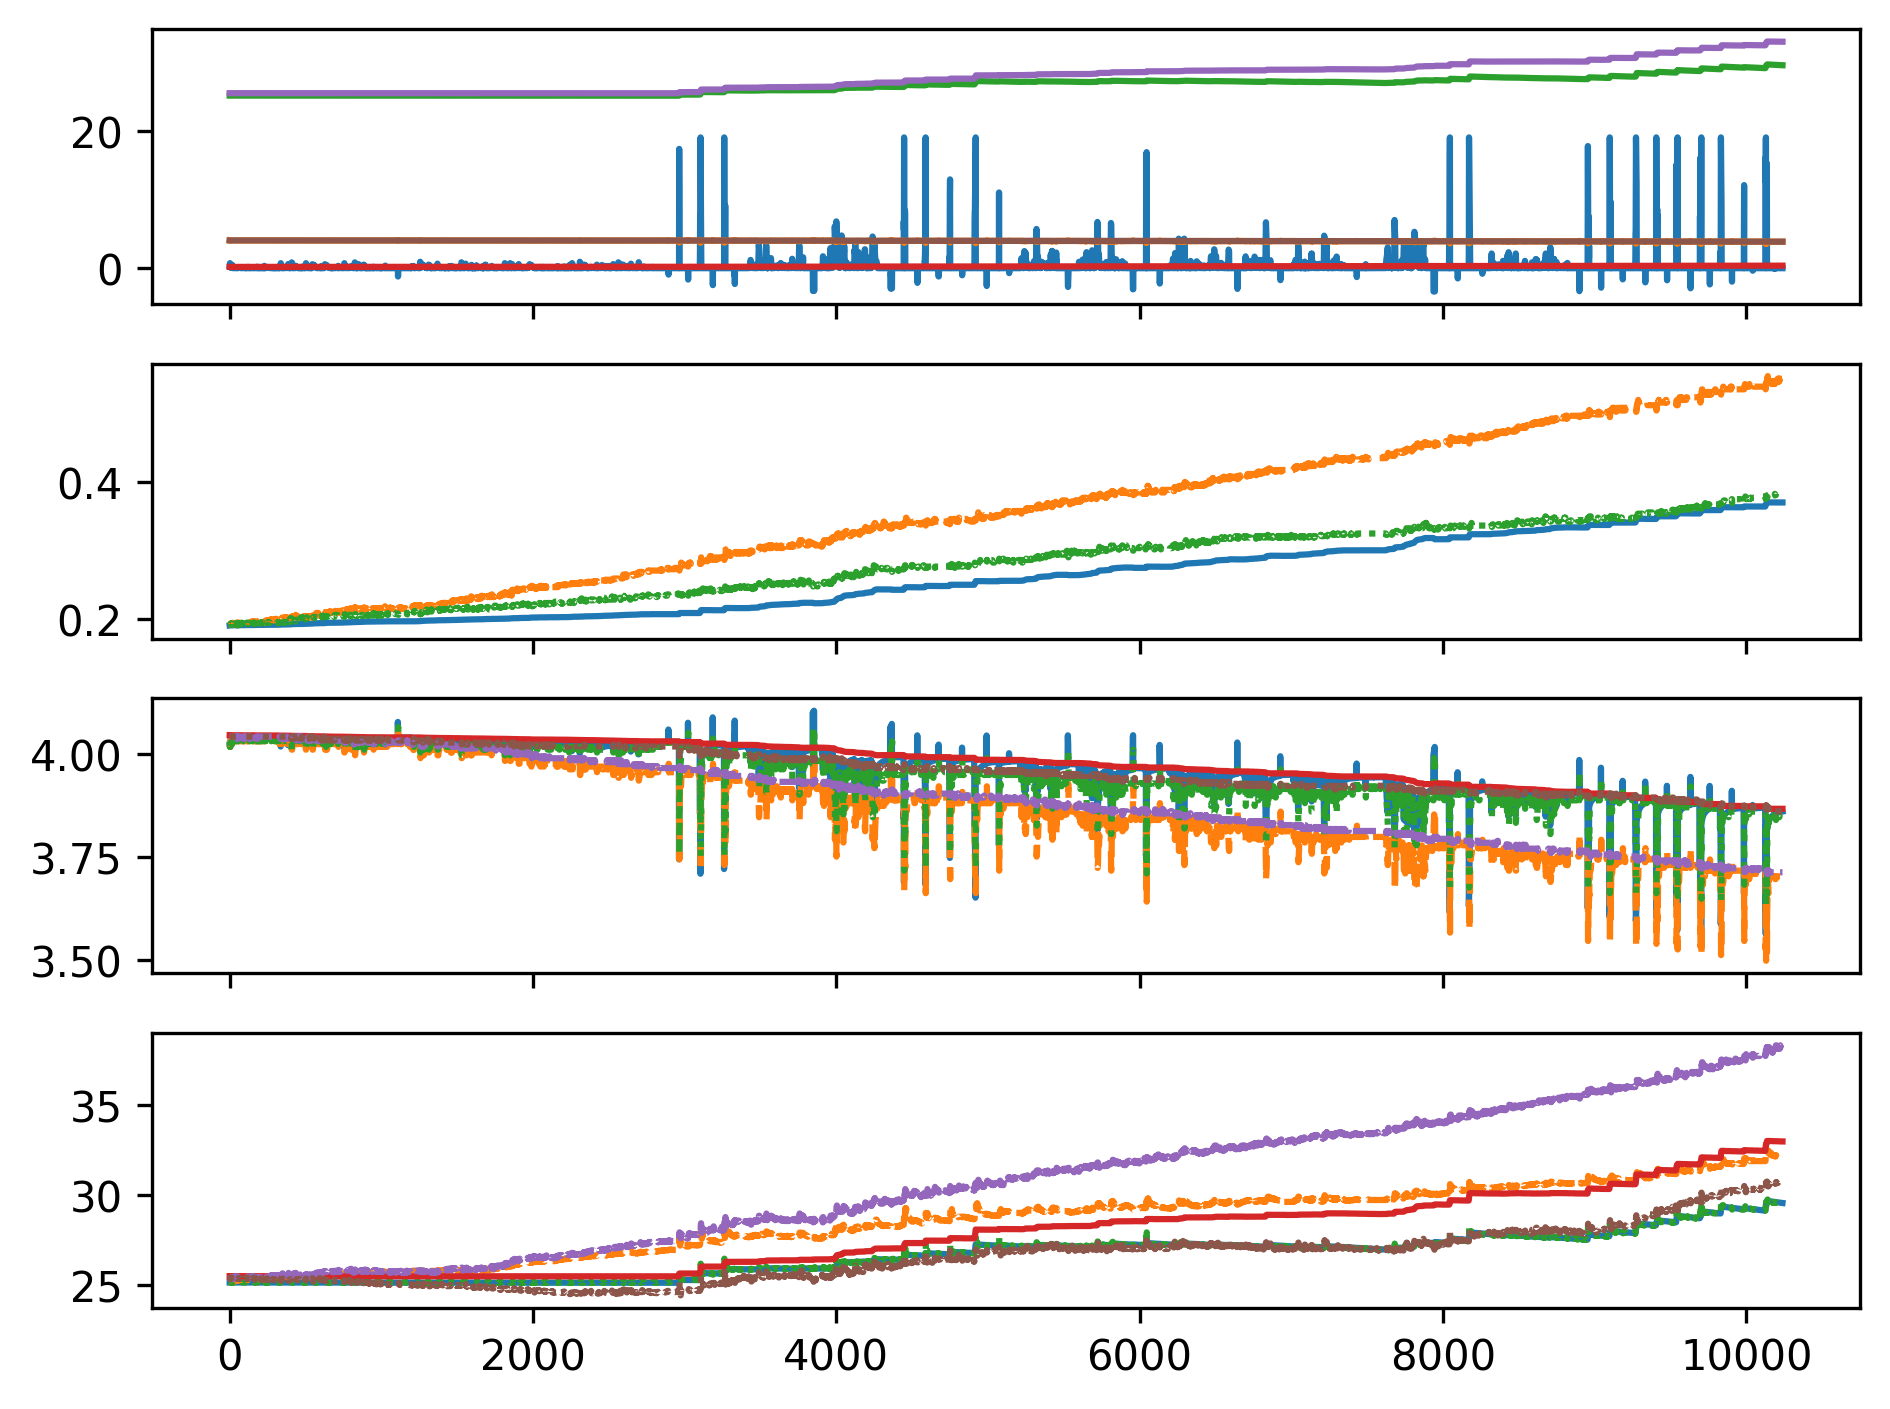

In [3]:
# transformer_trapz_2_RoPE_theta_1000
ckpt_path = "ckpt/transformer/v_15/1.3e-05_val_loss.pt"
model_args = ModelArgs()
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_16/1.3e-05_val_loss.pt
number of parameters: 113.26M
15007075.863204062 131044.79541136324


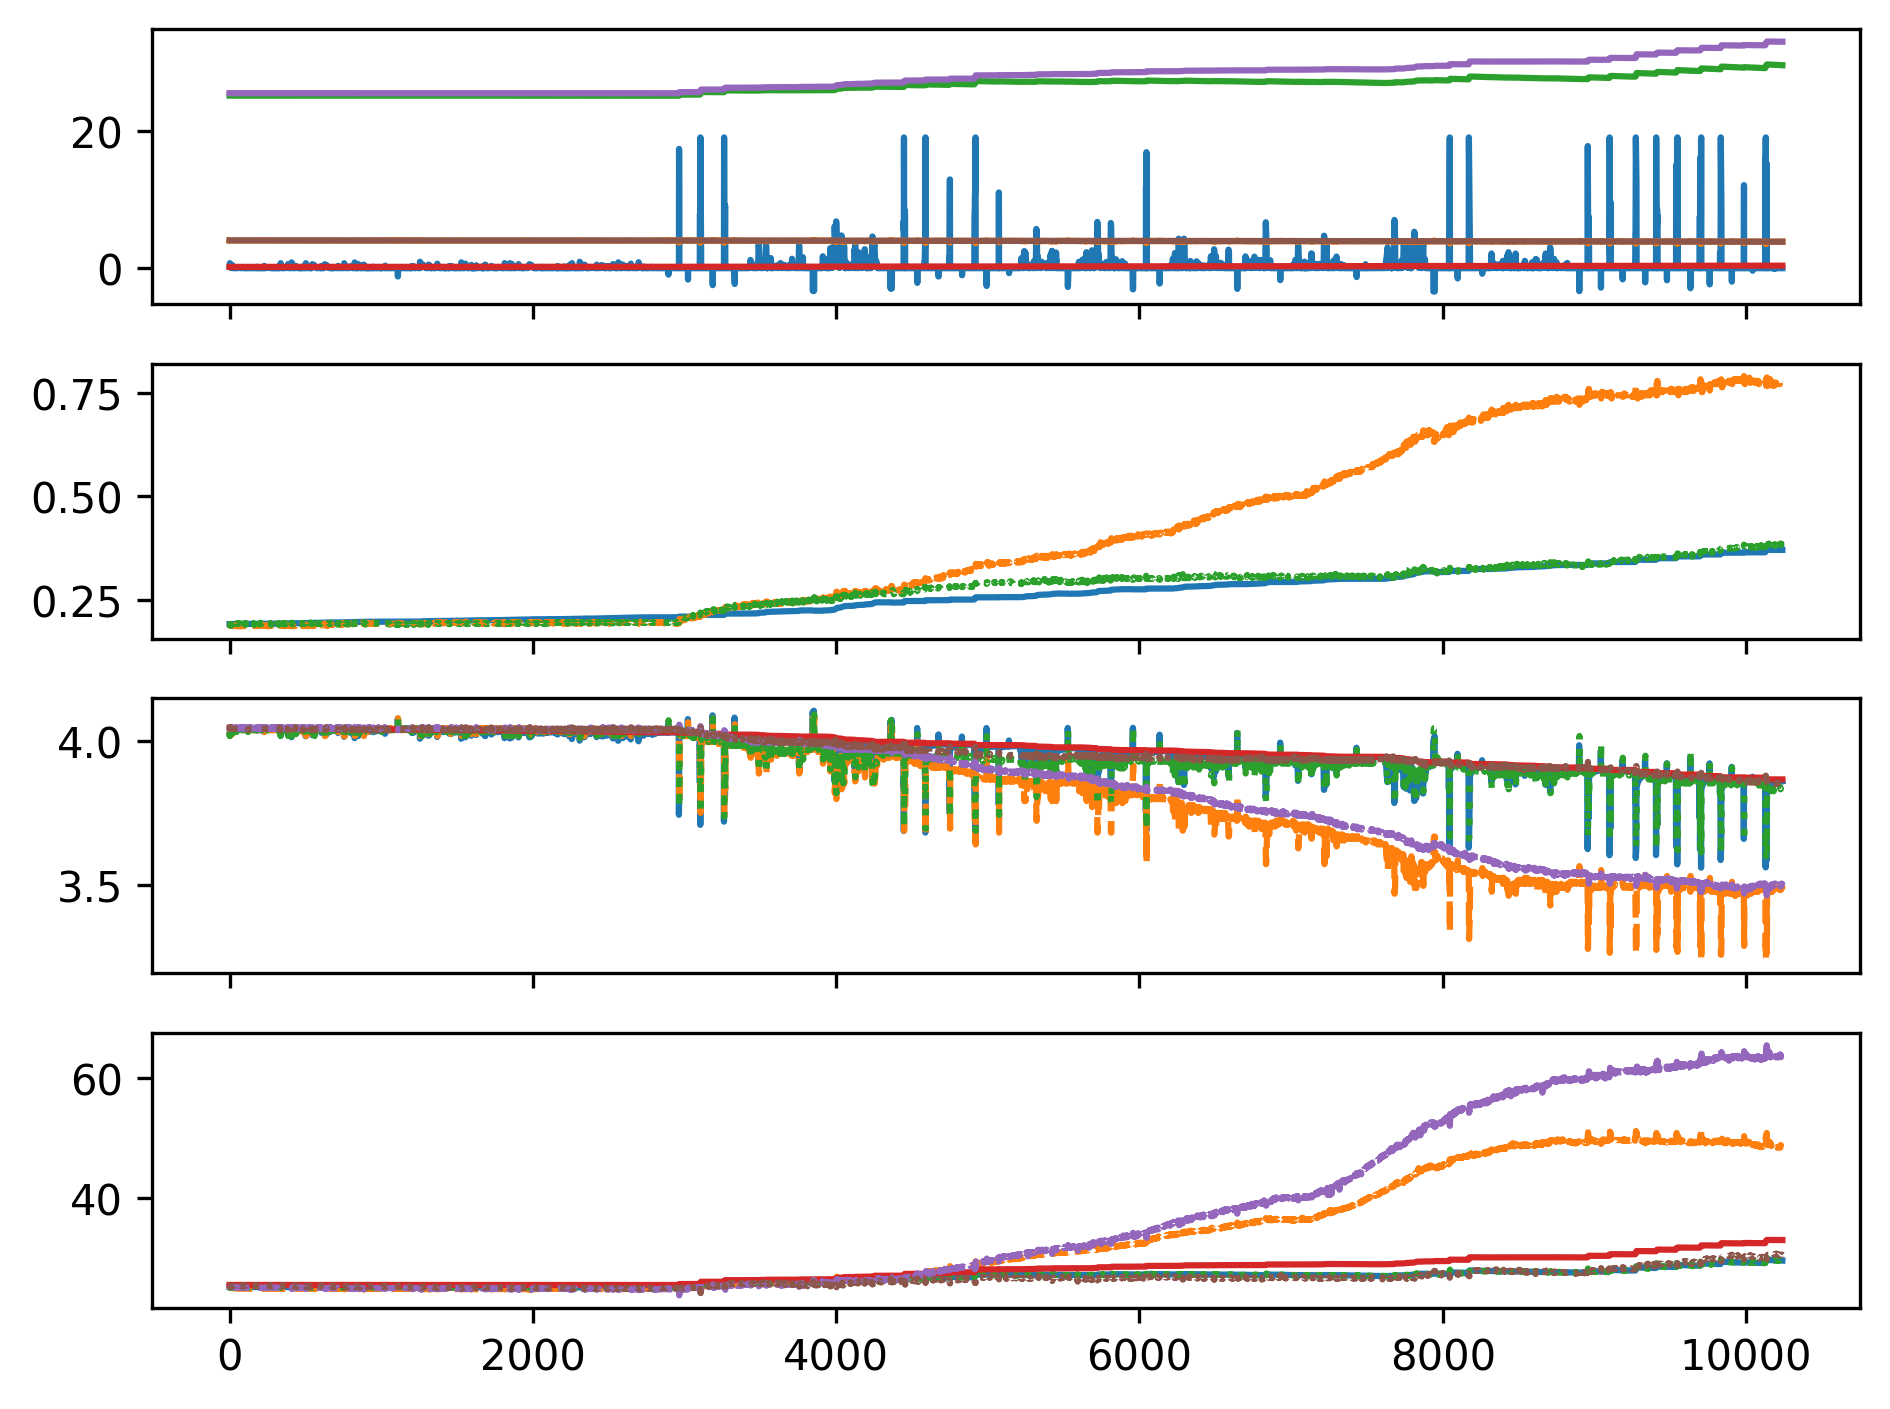

In [3]:
# transformer_trapz_2_RoPE_theta_100000
ckpt_path = "ckpt/transformer/v_16/1.3e-05_val_loss.pt"
model_args = ModelArgs()
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_17/1.3e-05_val_loss.pt
number of parameters: 113.26M
15411451.722717285 1409.7271452500136


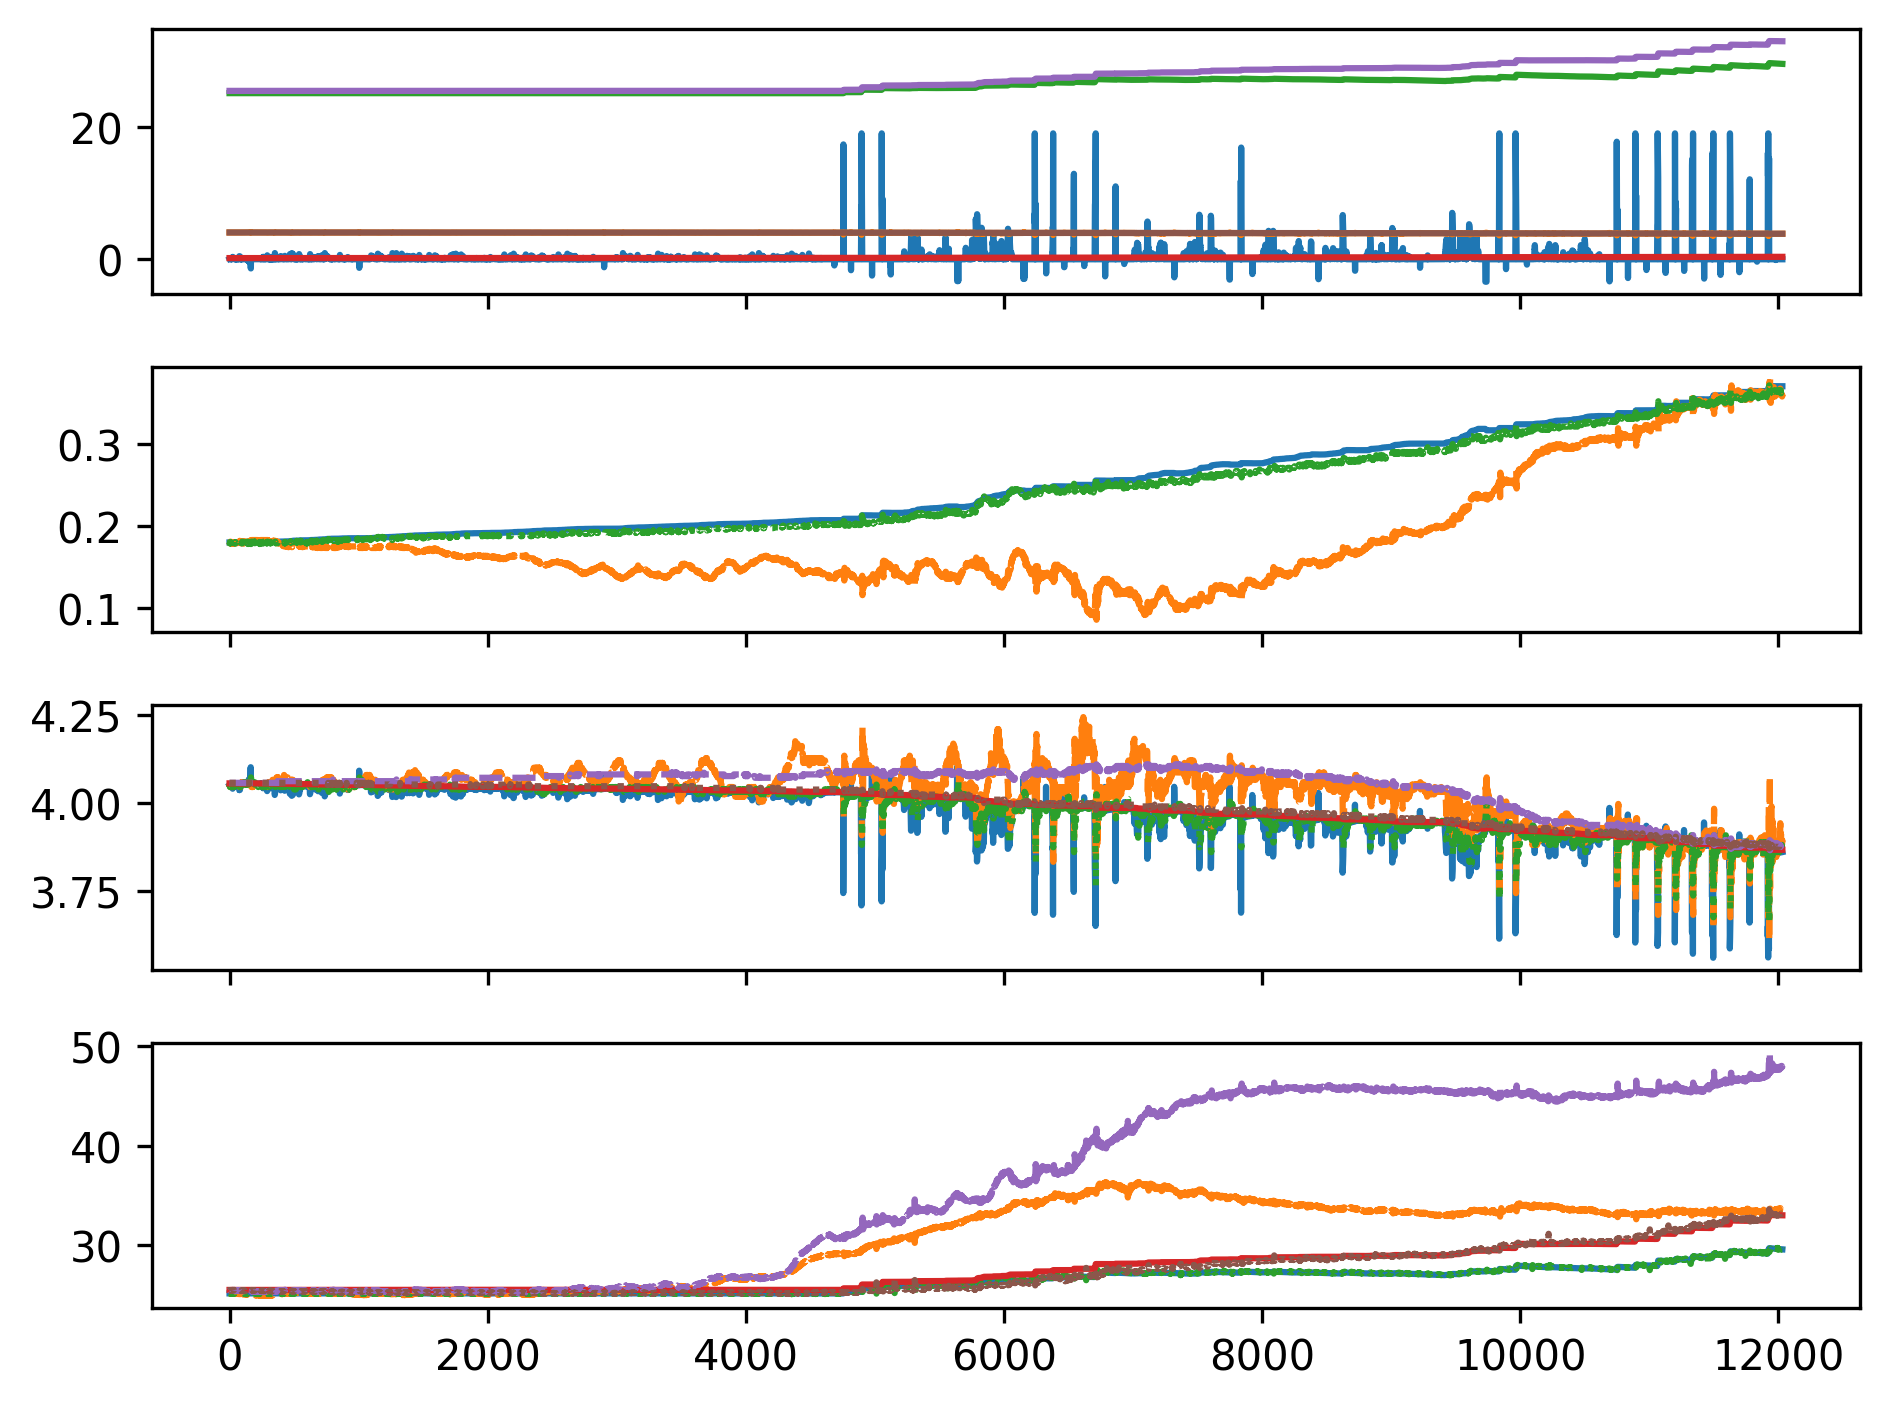

In [3]:
# transformer_trapz_abs_seqlen256
############## change seq multiplyer for prections to with *2*2*2 in util/prepare_data.py and print loop above
ckpt_path = "ckpt/transformer/v_17/1.3e-05_val_loss.pt"
model_args = ModelArgs(pe_type = "abs")
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_20/2.1e-05_val_loss.pt
number of parameters: 113.26M
62741498.408447266 629769.2435243167


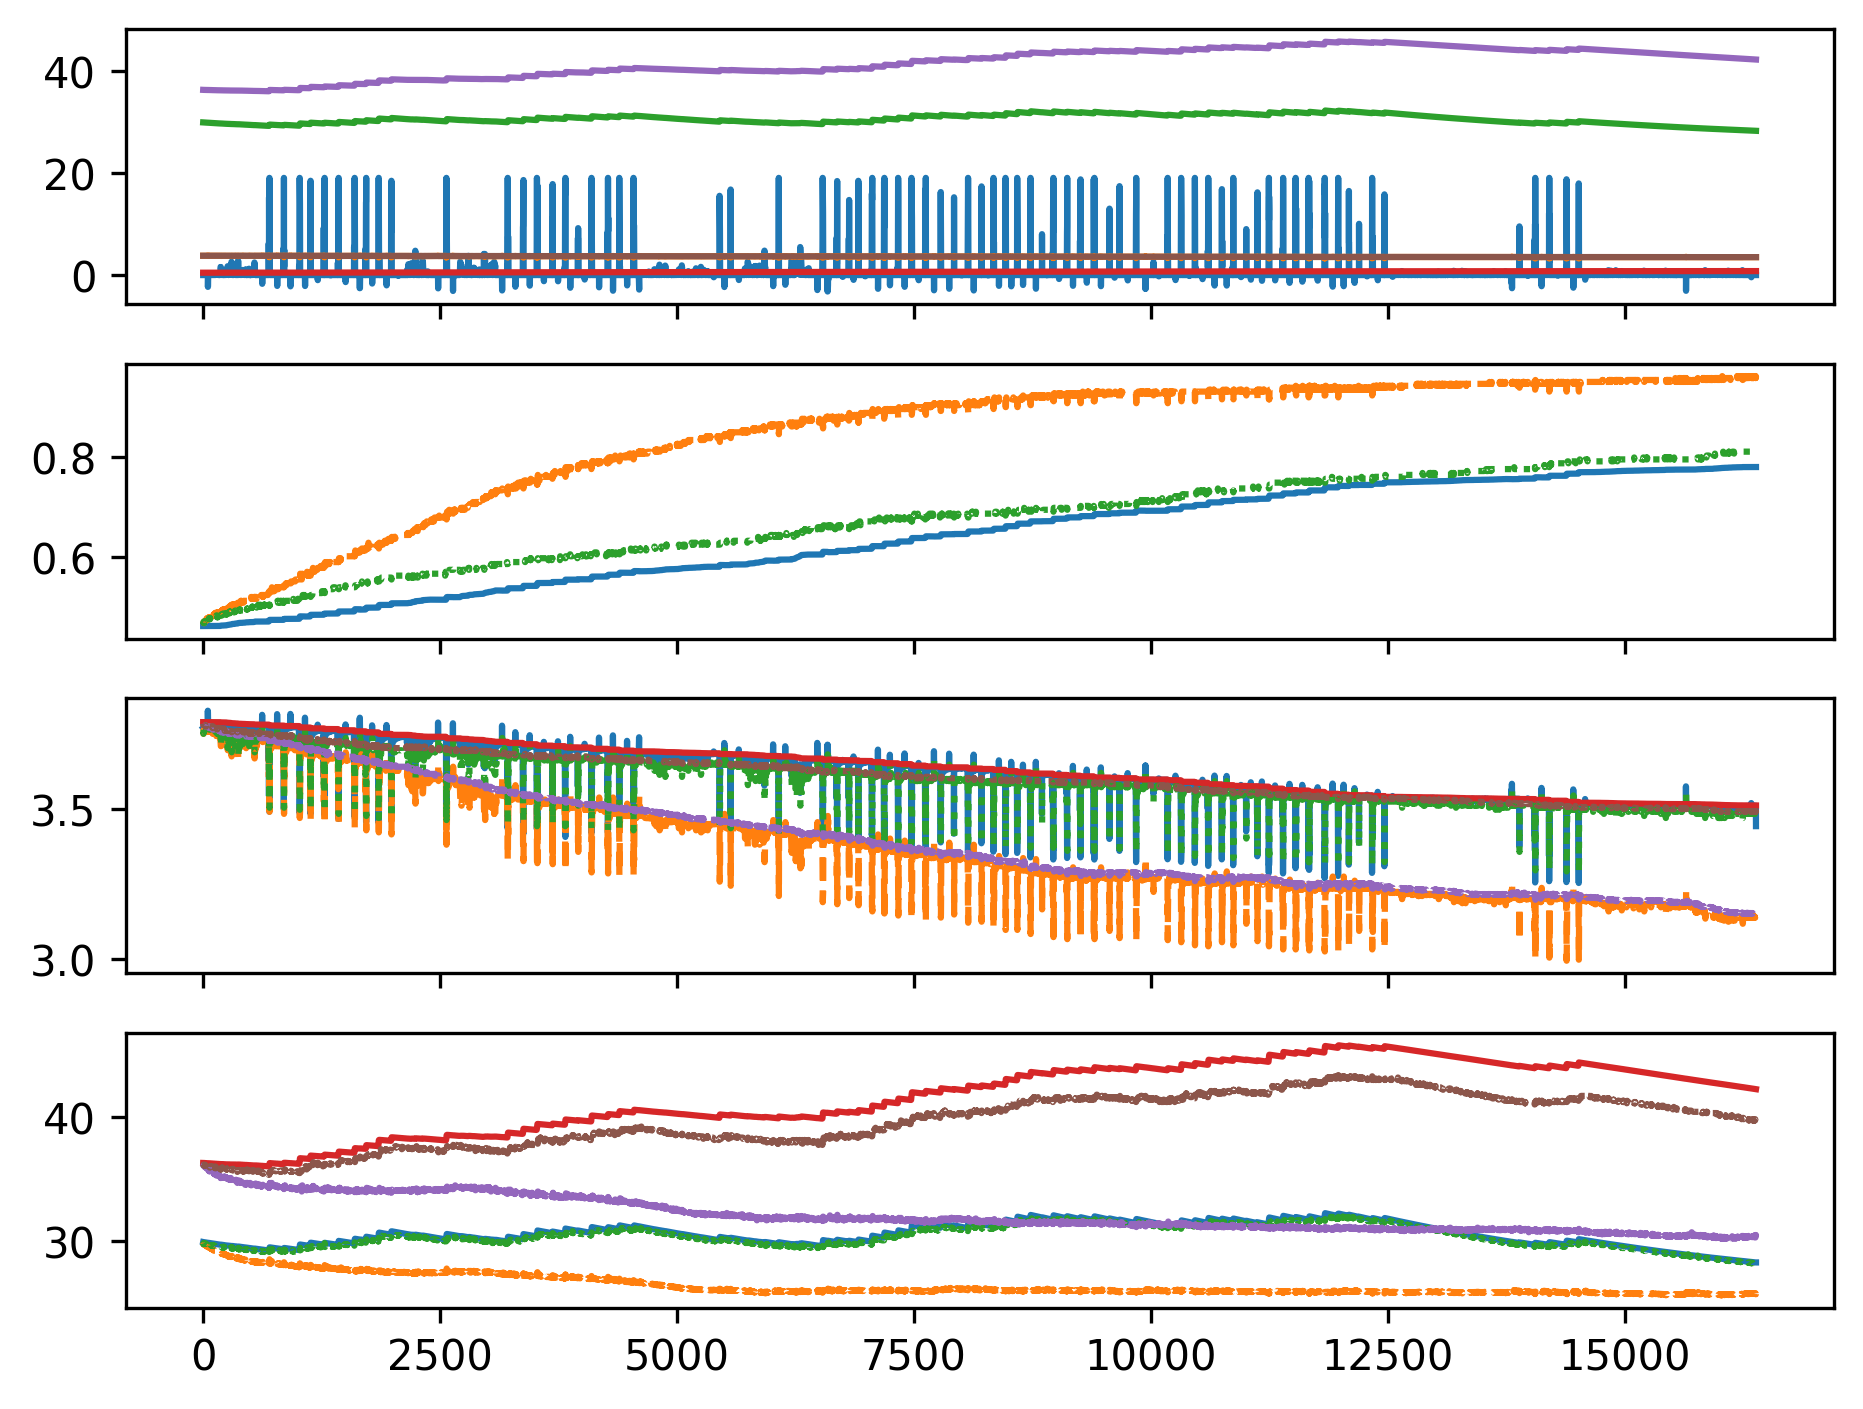

In [3]:
# transformer_trapz_seqlen16k
############## change seq multiplyer for prections to with *2*2*2 in util/prepare_data.py and print loop above
ckpt_path = "ckpt/transformer/v_20/2.1e-05_val_loss.pt"
model_args = ModelArgs()
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_21/3.9e-05_val_loss.pt
number of parameters: 113.26M
1294328.1258130223 7605.335097899893


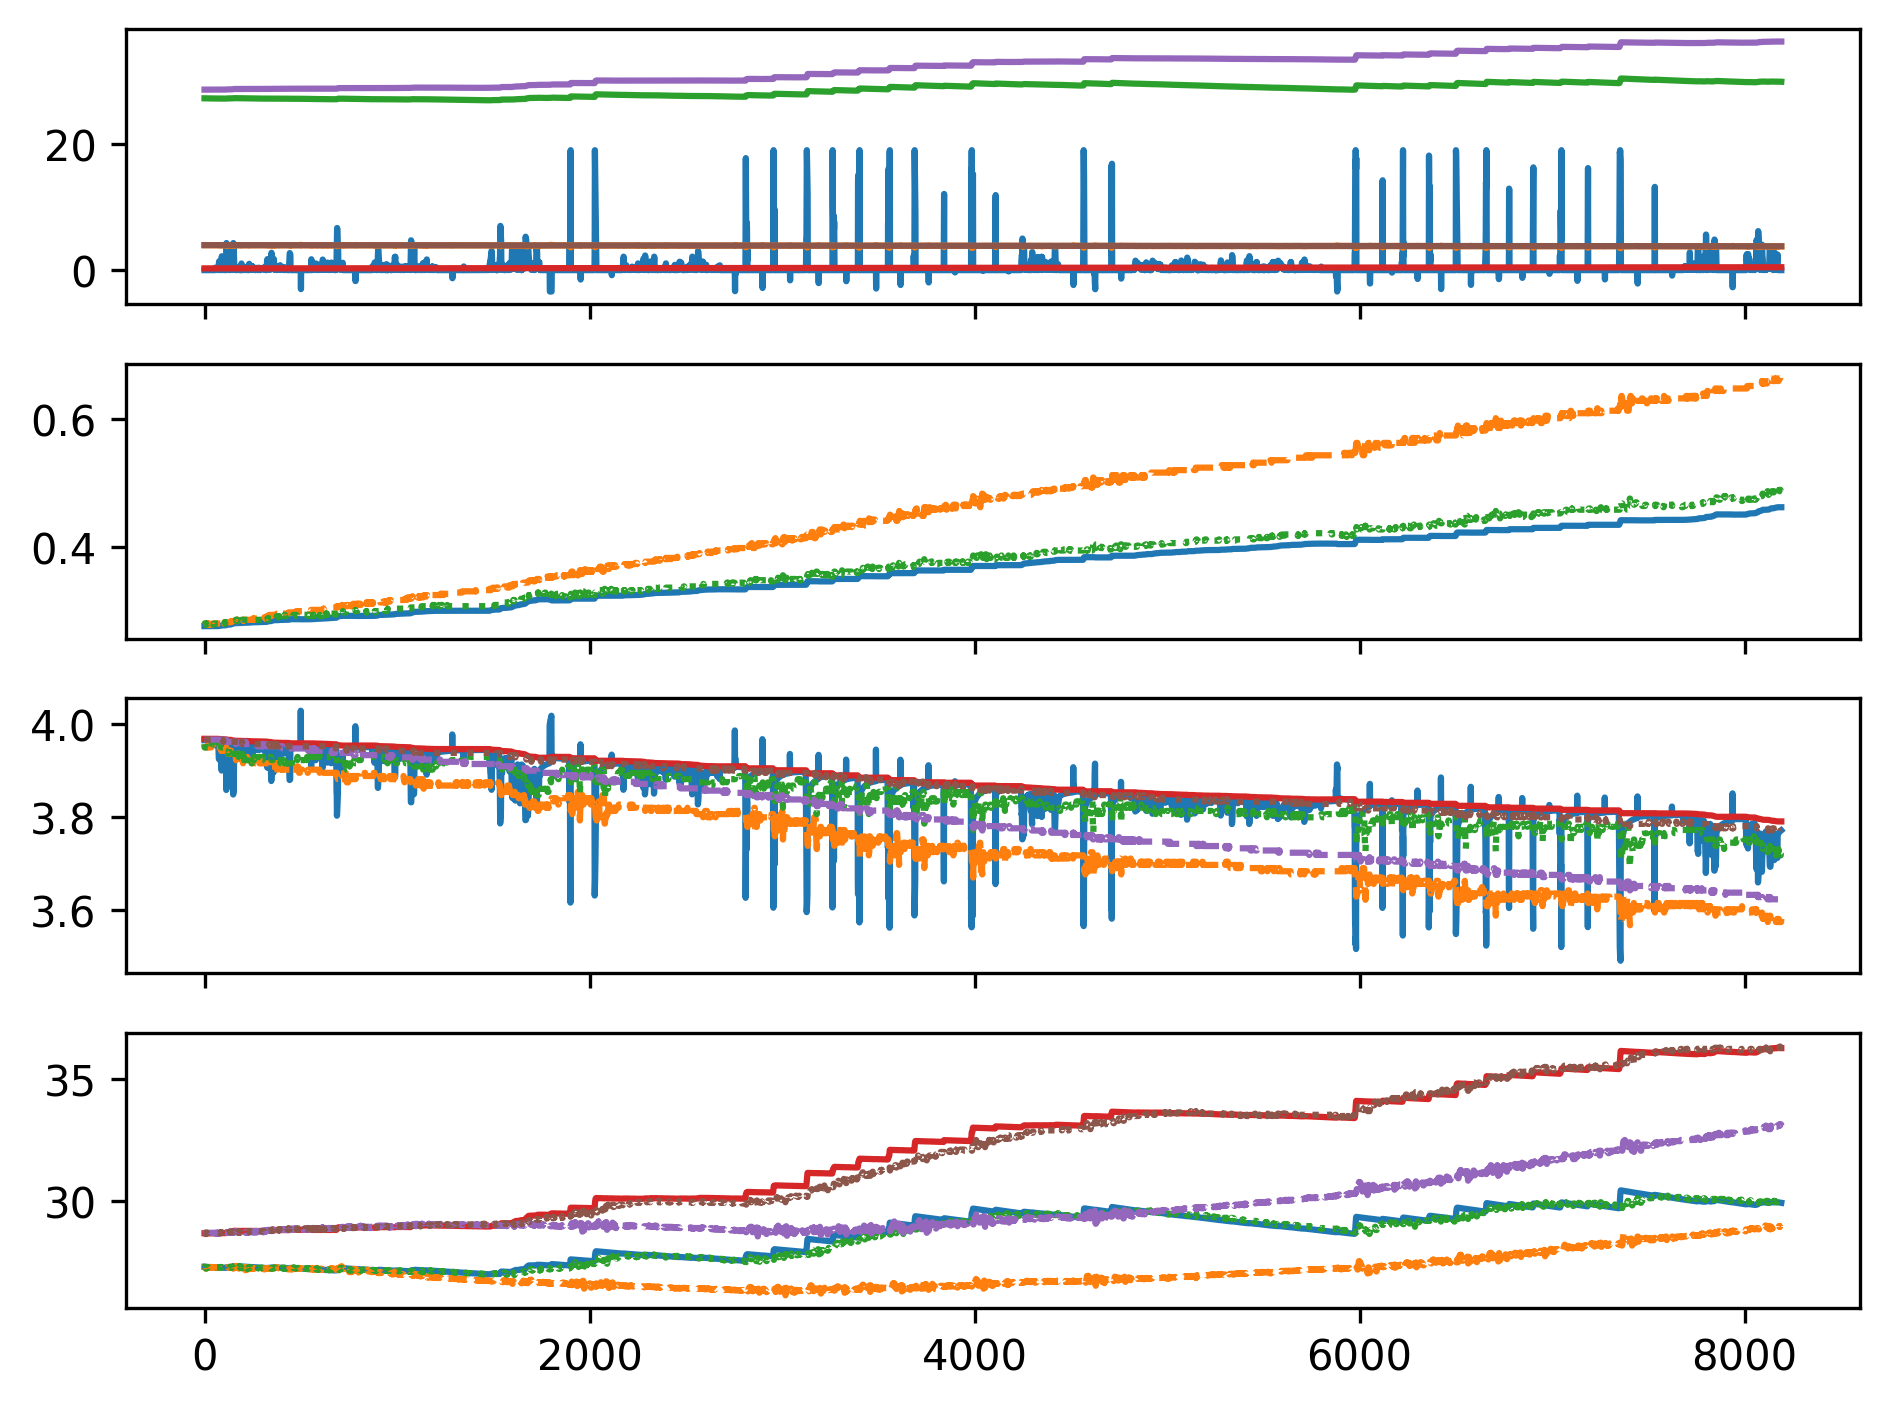

In [3]:
# transformer_trapz_seqlen8k_peabs
############## change seq multiplyer for prections to with *2*2*2 in util/prepare_data.py and print loop above
ckpt_path = "ckpt/transformer/v_21/3.9e-05_val_loss.pt"
model_args = ModelArgs(pe_type="abs")
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_22/1.1e-05_val_loss.pt
number of parameters: 113.26M
3505592.494795084 3798466.8171029687


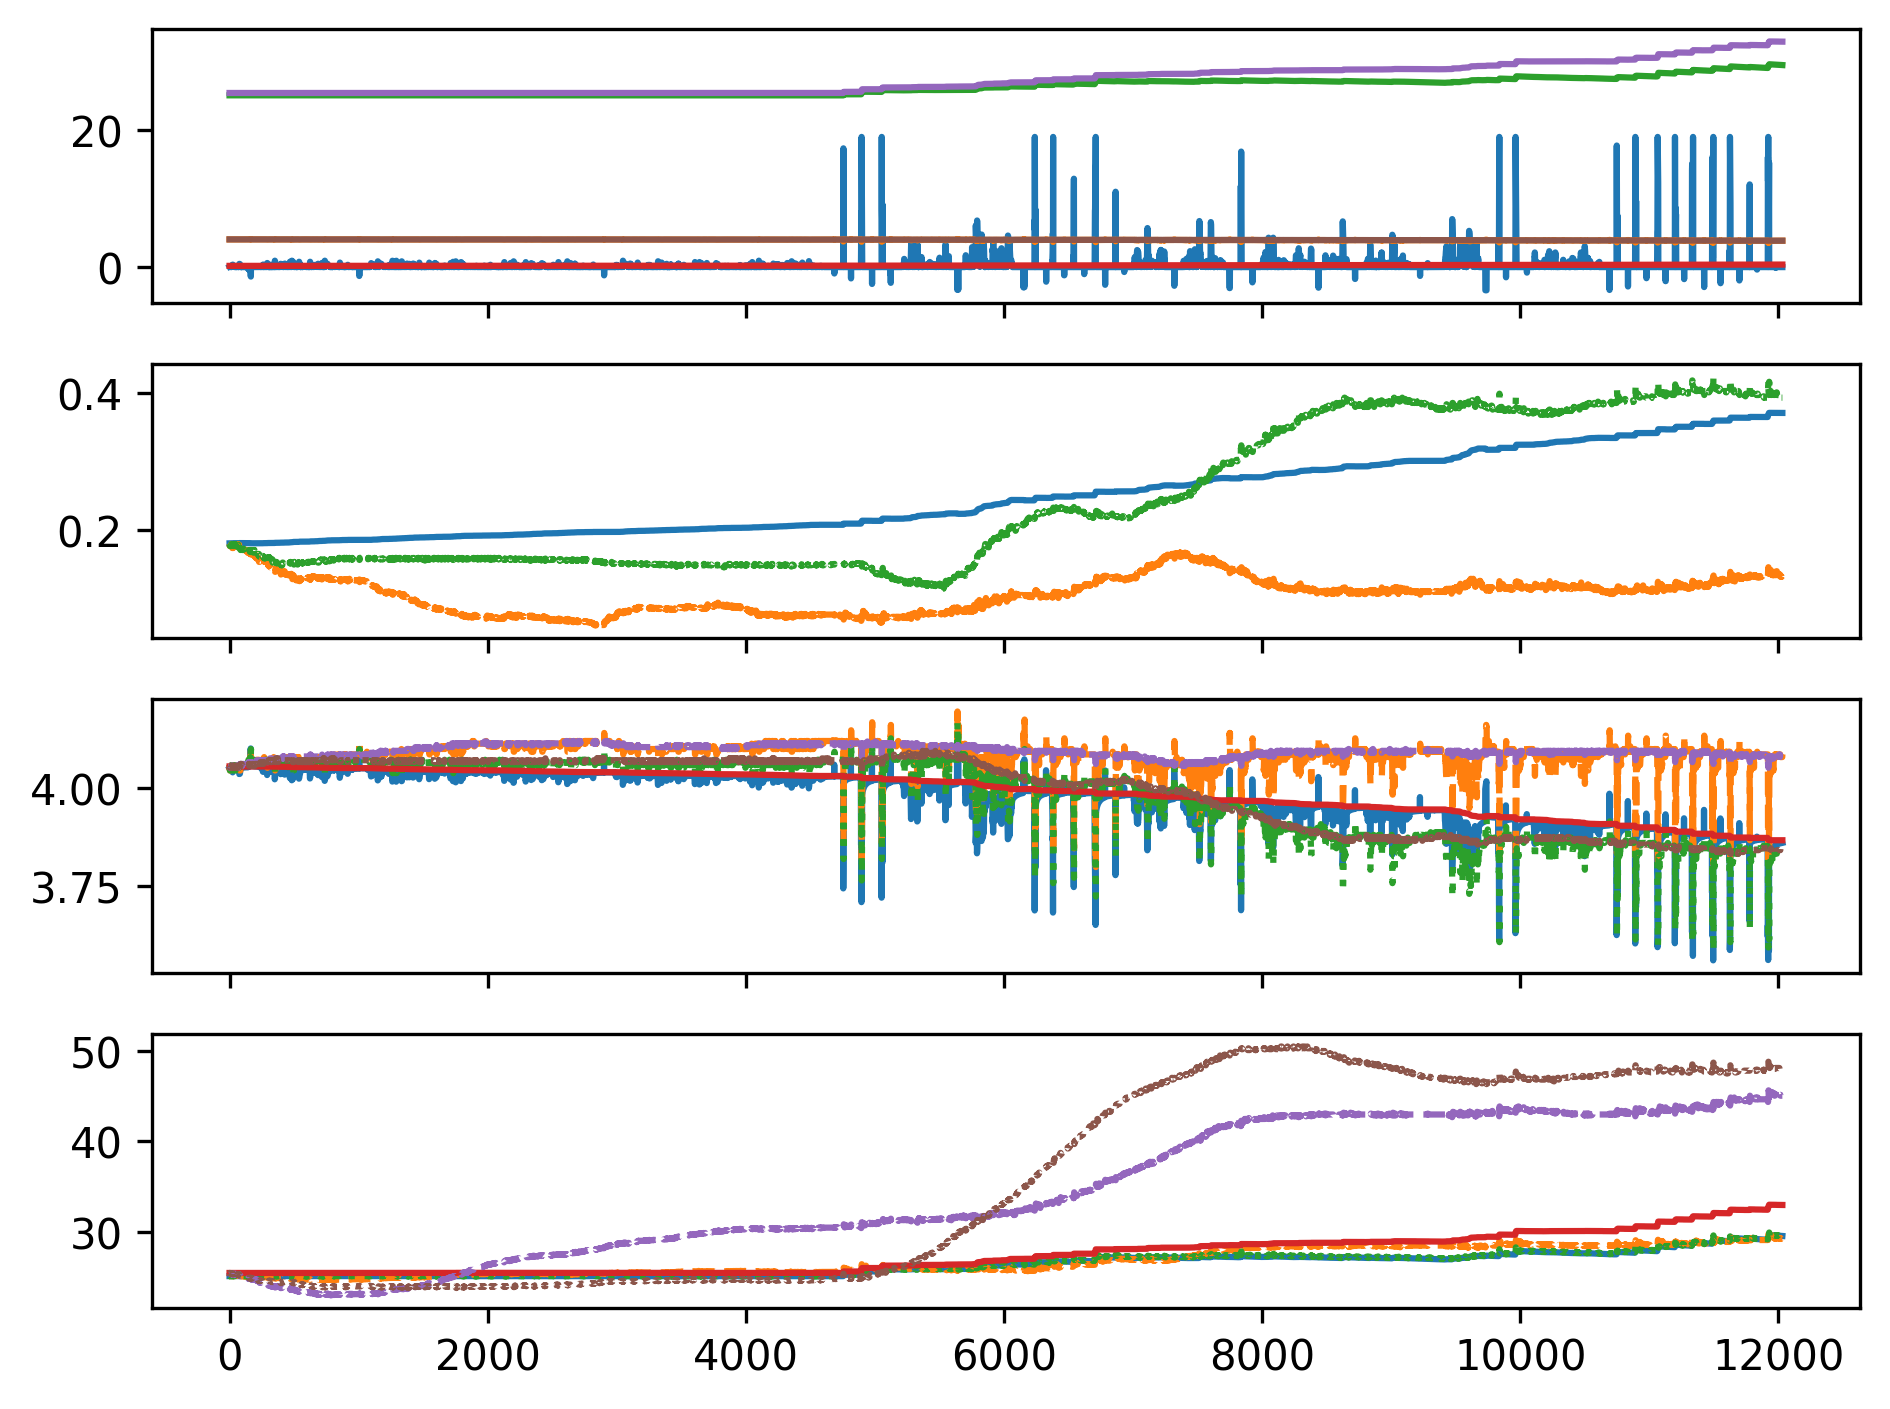

In [3]:
# transformer_trapz_seq256
############## change seq multiplyer for prections to with *2*2*2 in util/prepare_data.py and print loop above
ckpt_path = "ckpt/transformer/v_22/1.1e-05_val_loss.pt"
model_args = ModelArgs()
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_23/1.7e-04_val_loss.pt
number of parameters: 113.27M
267573.3877386488 17653.511104080826


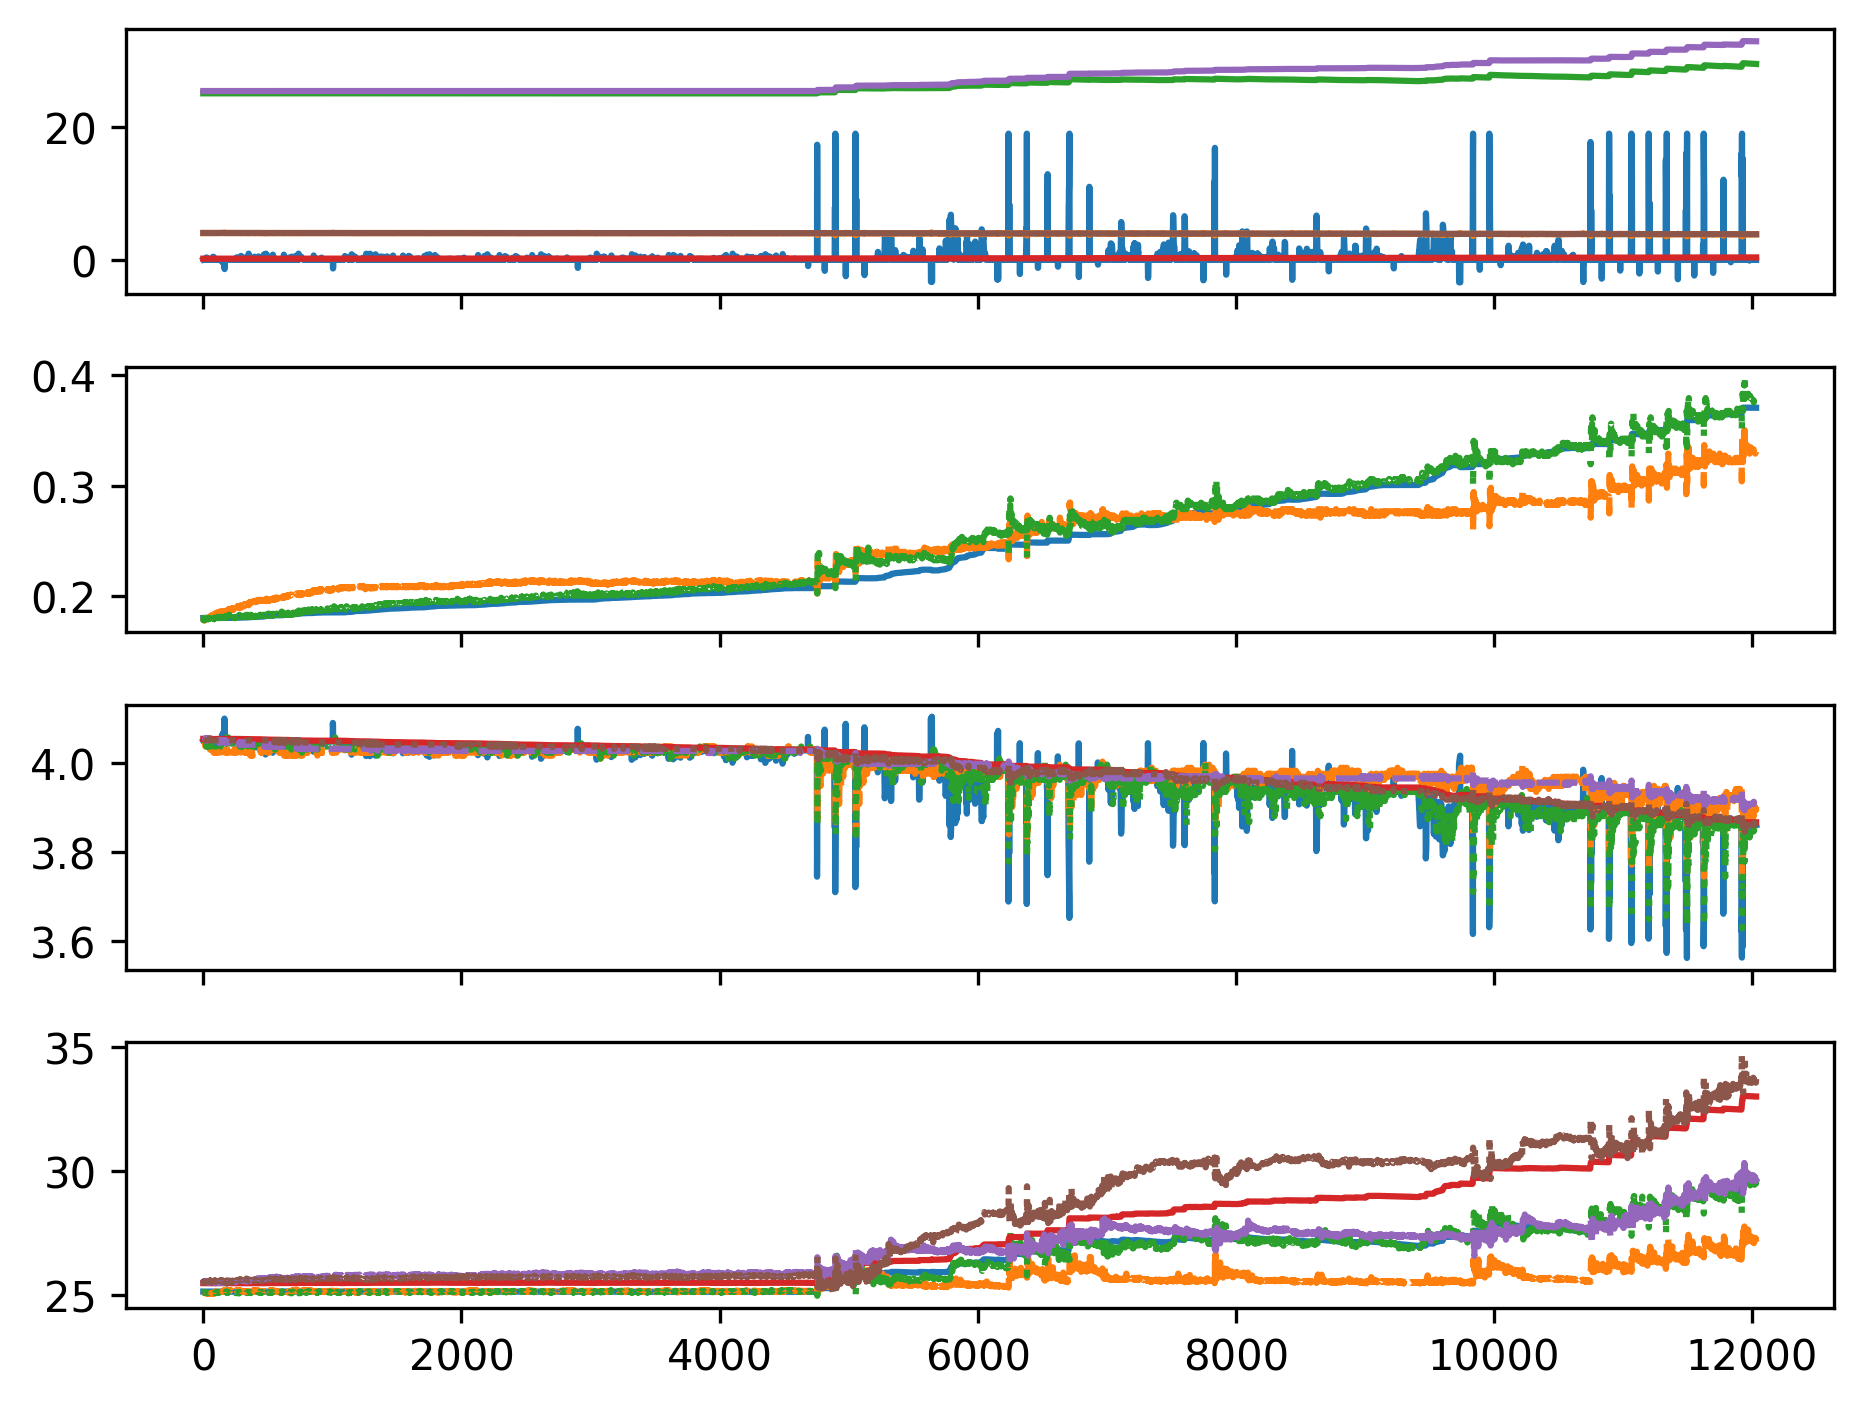

In [3]:
# transformer_trapz_seqlen256_6out_peabs
############## change seq multiplyer for prections to with *2*2*2 in util/prepare_data.py and print loop above
ckpt_path = "ckpt/transformer/v_23/1.7e-04_val_loss.pt"
model_args = ModelArgs(pe_type="abs", dim_out = 6)
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_25/1.2e-04_val_loss.pt
number of parameters: 113.26M
17.15261072013527 271209.74104974046


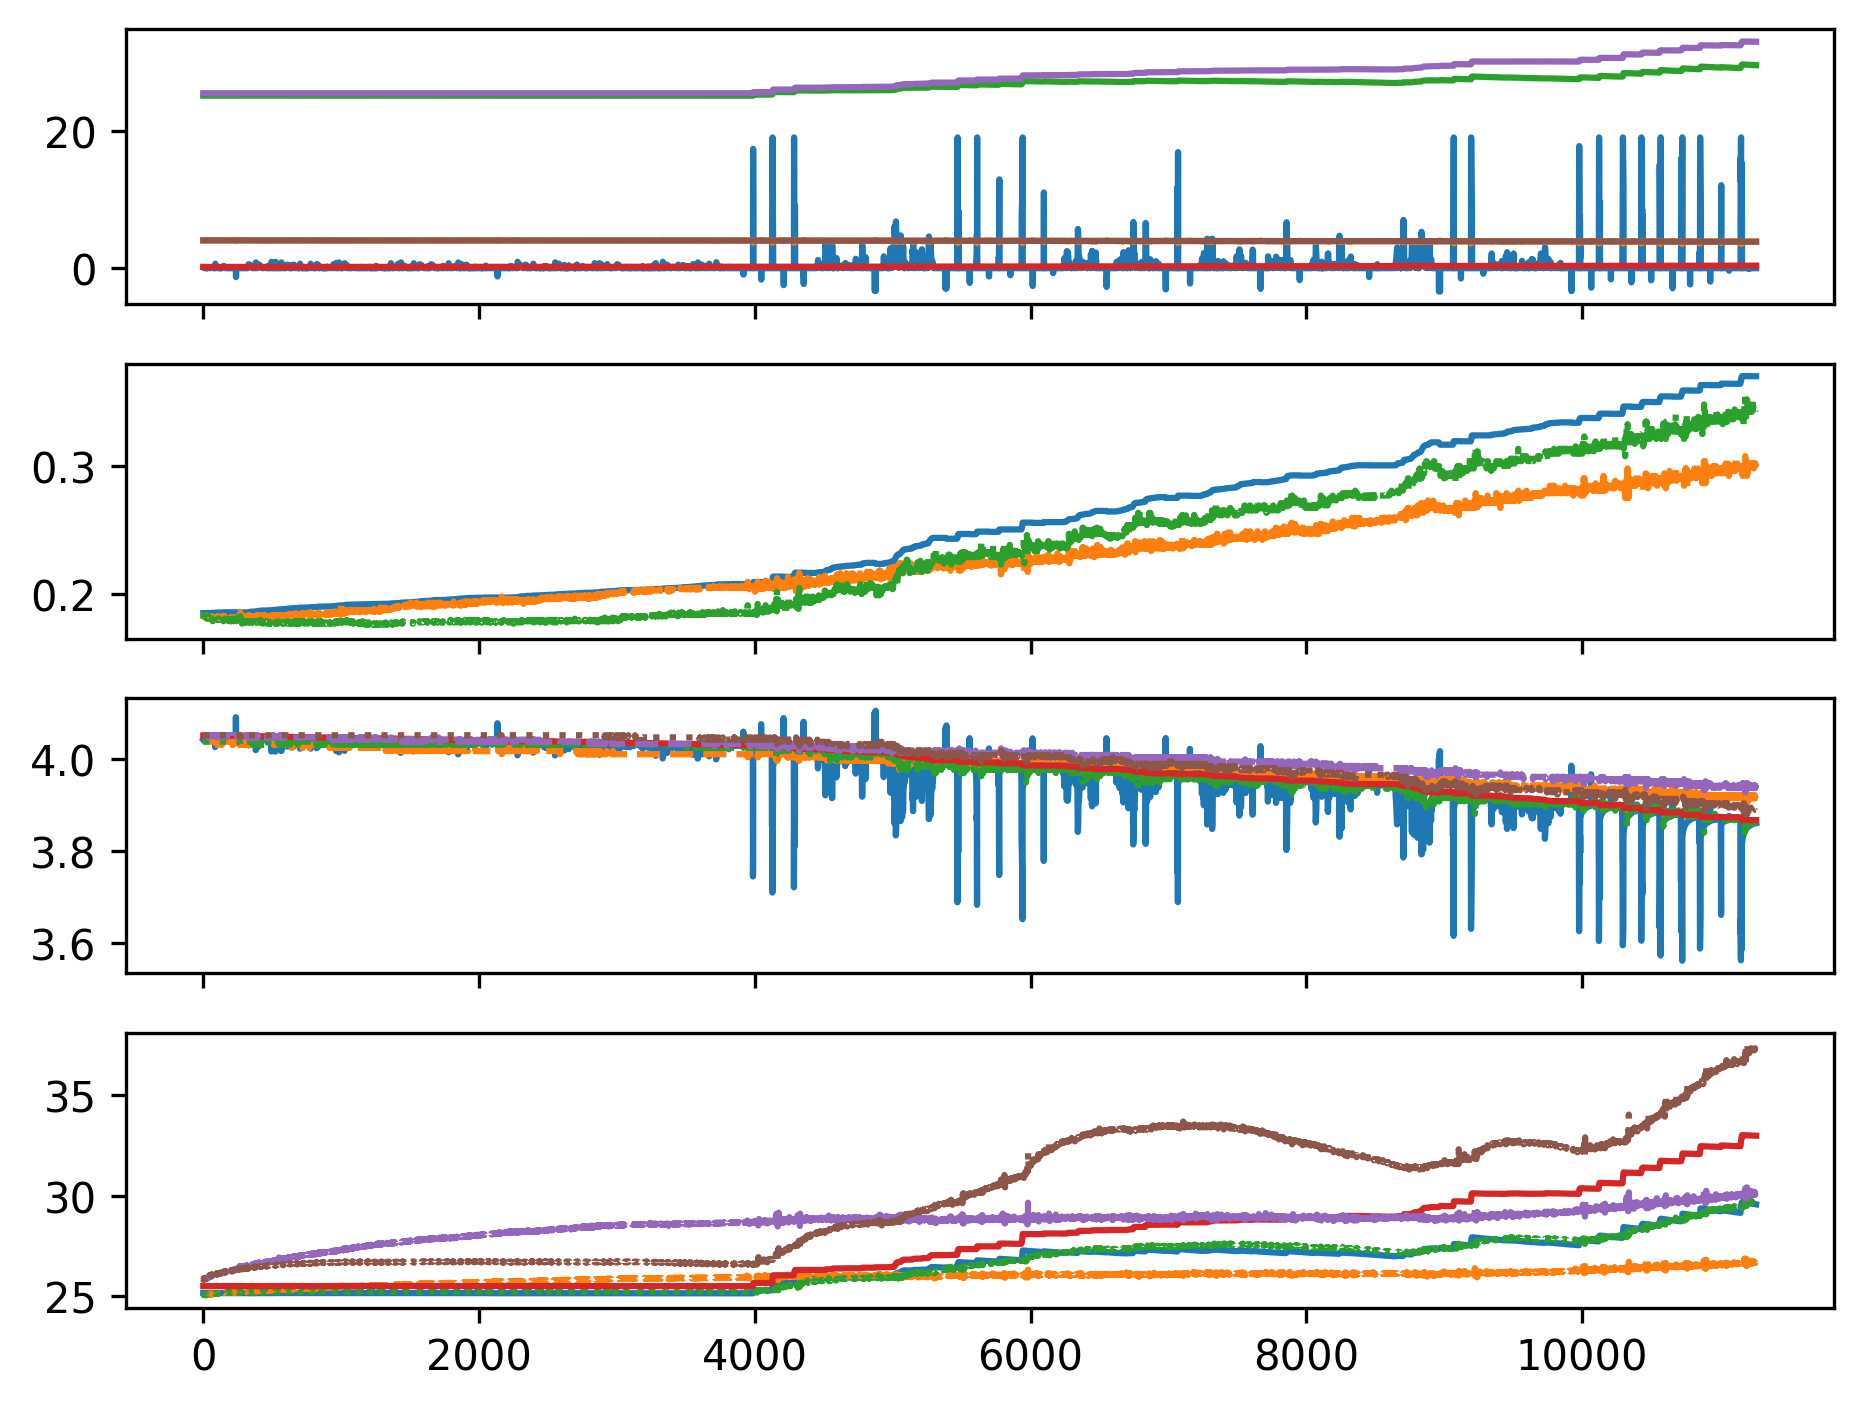

In [3]:
# transformer_trapz_RoPE+peabs
############## change seq multiplyer for prections to with *2*2*2 in util/prepare_data.py and print loop above
ckpt_path = "ckpt/transformer/v_25/1.2e-04_val_loss.pt"
model_args = ModelArgs(pe_type="RoPE")
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_26/3.2e-04_val_loss.pt
number of parameters: 113.26M
12180.75945868768 75496.73564548139


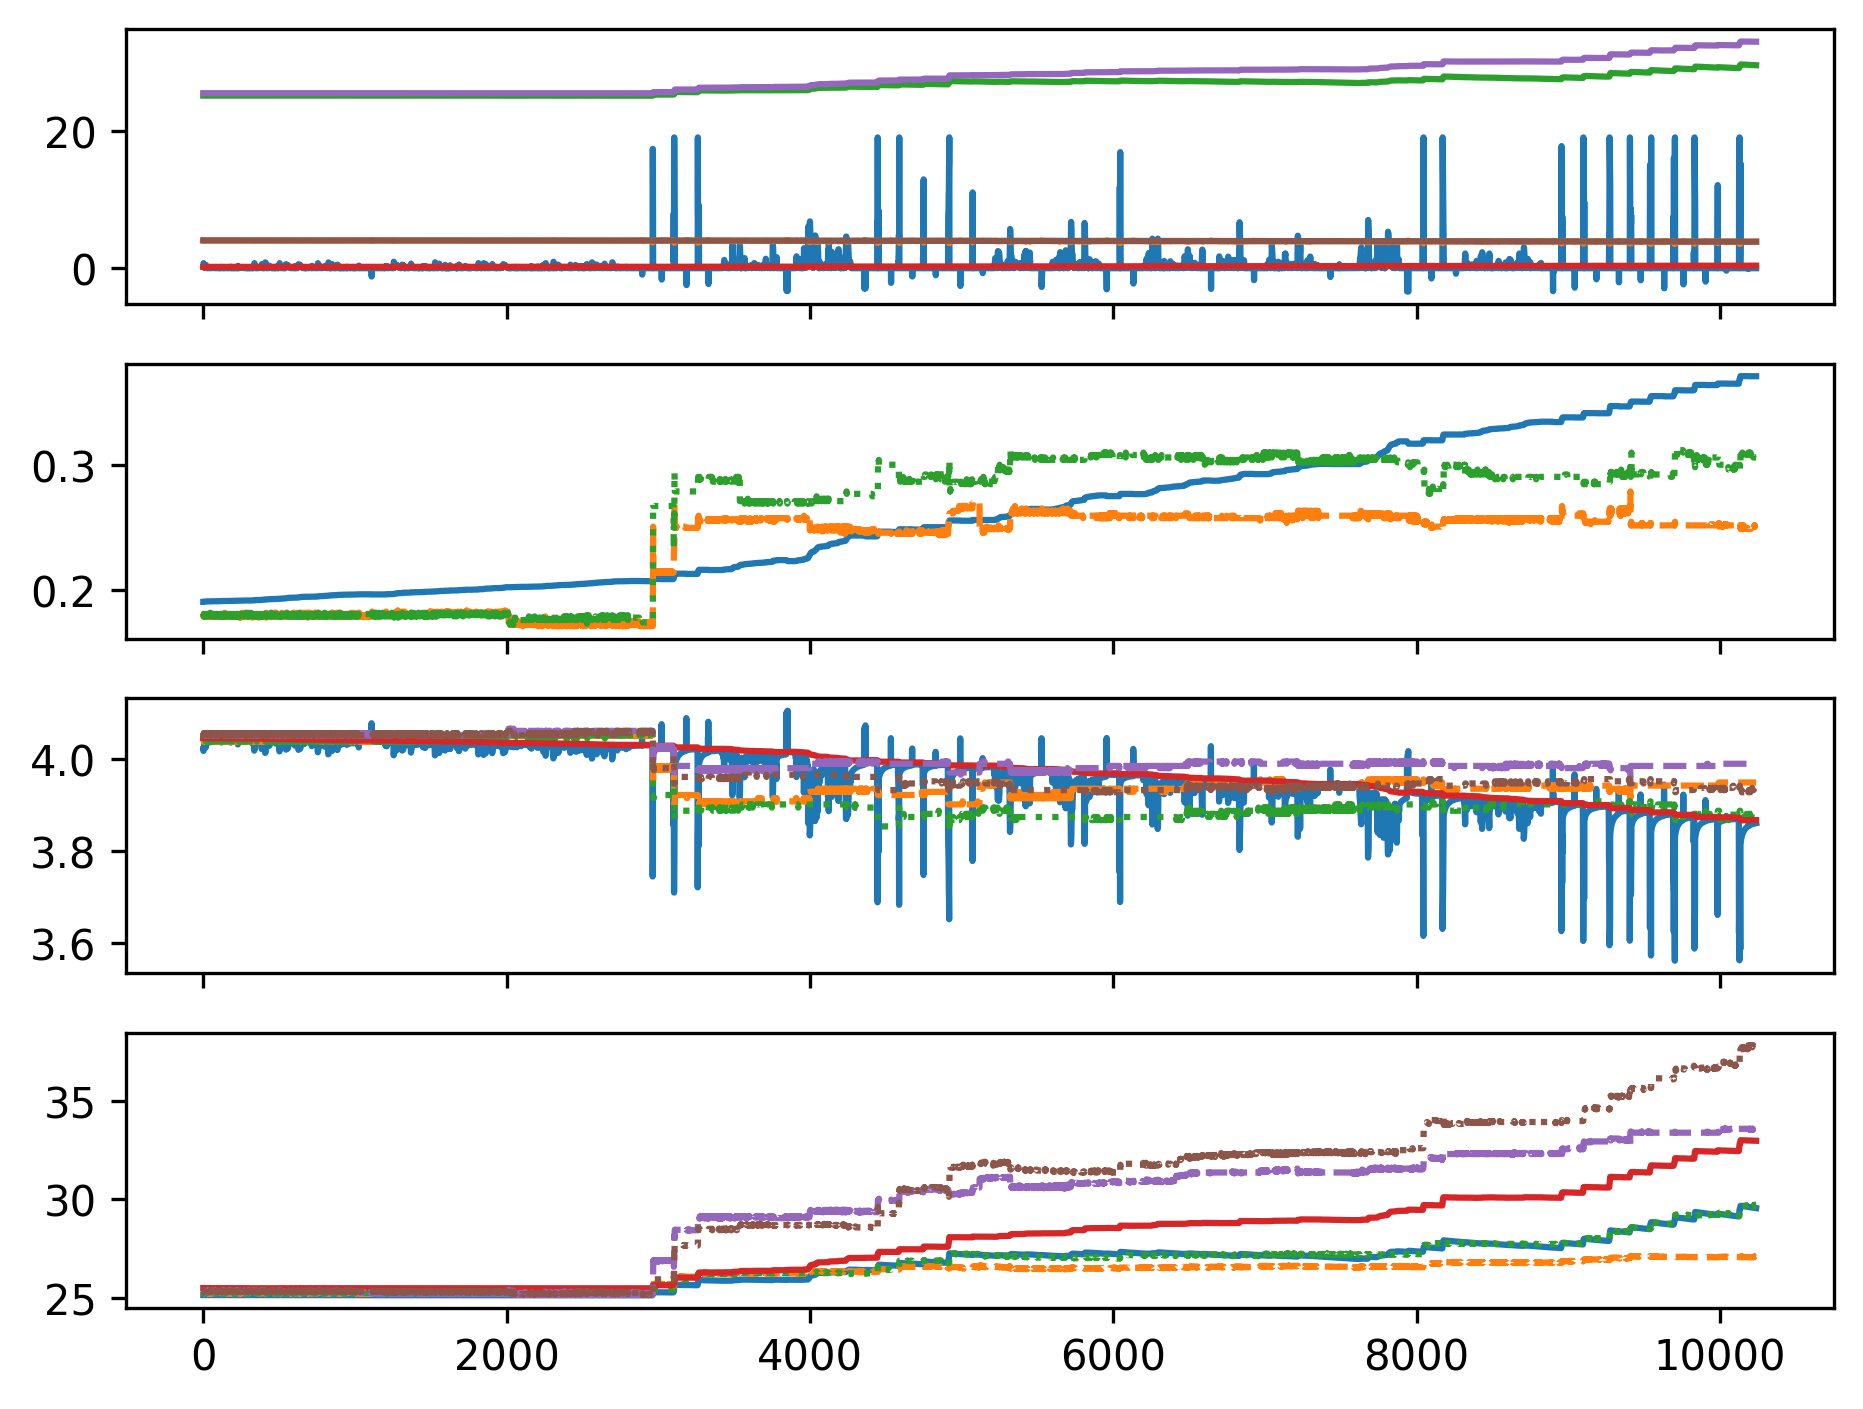

In [3]:
# transformer_trapz_NoPE
############## change files
ckpt_path = "ckpt/transformer/v_26/3.2e-04_val_loss.pt"
model_args = ModelArgs()
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_58/1.4e-05_val_loss.pt
number of parameters: 113.26M
5942.980460711755 71656.82639330998


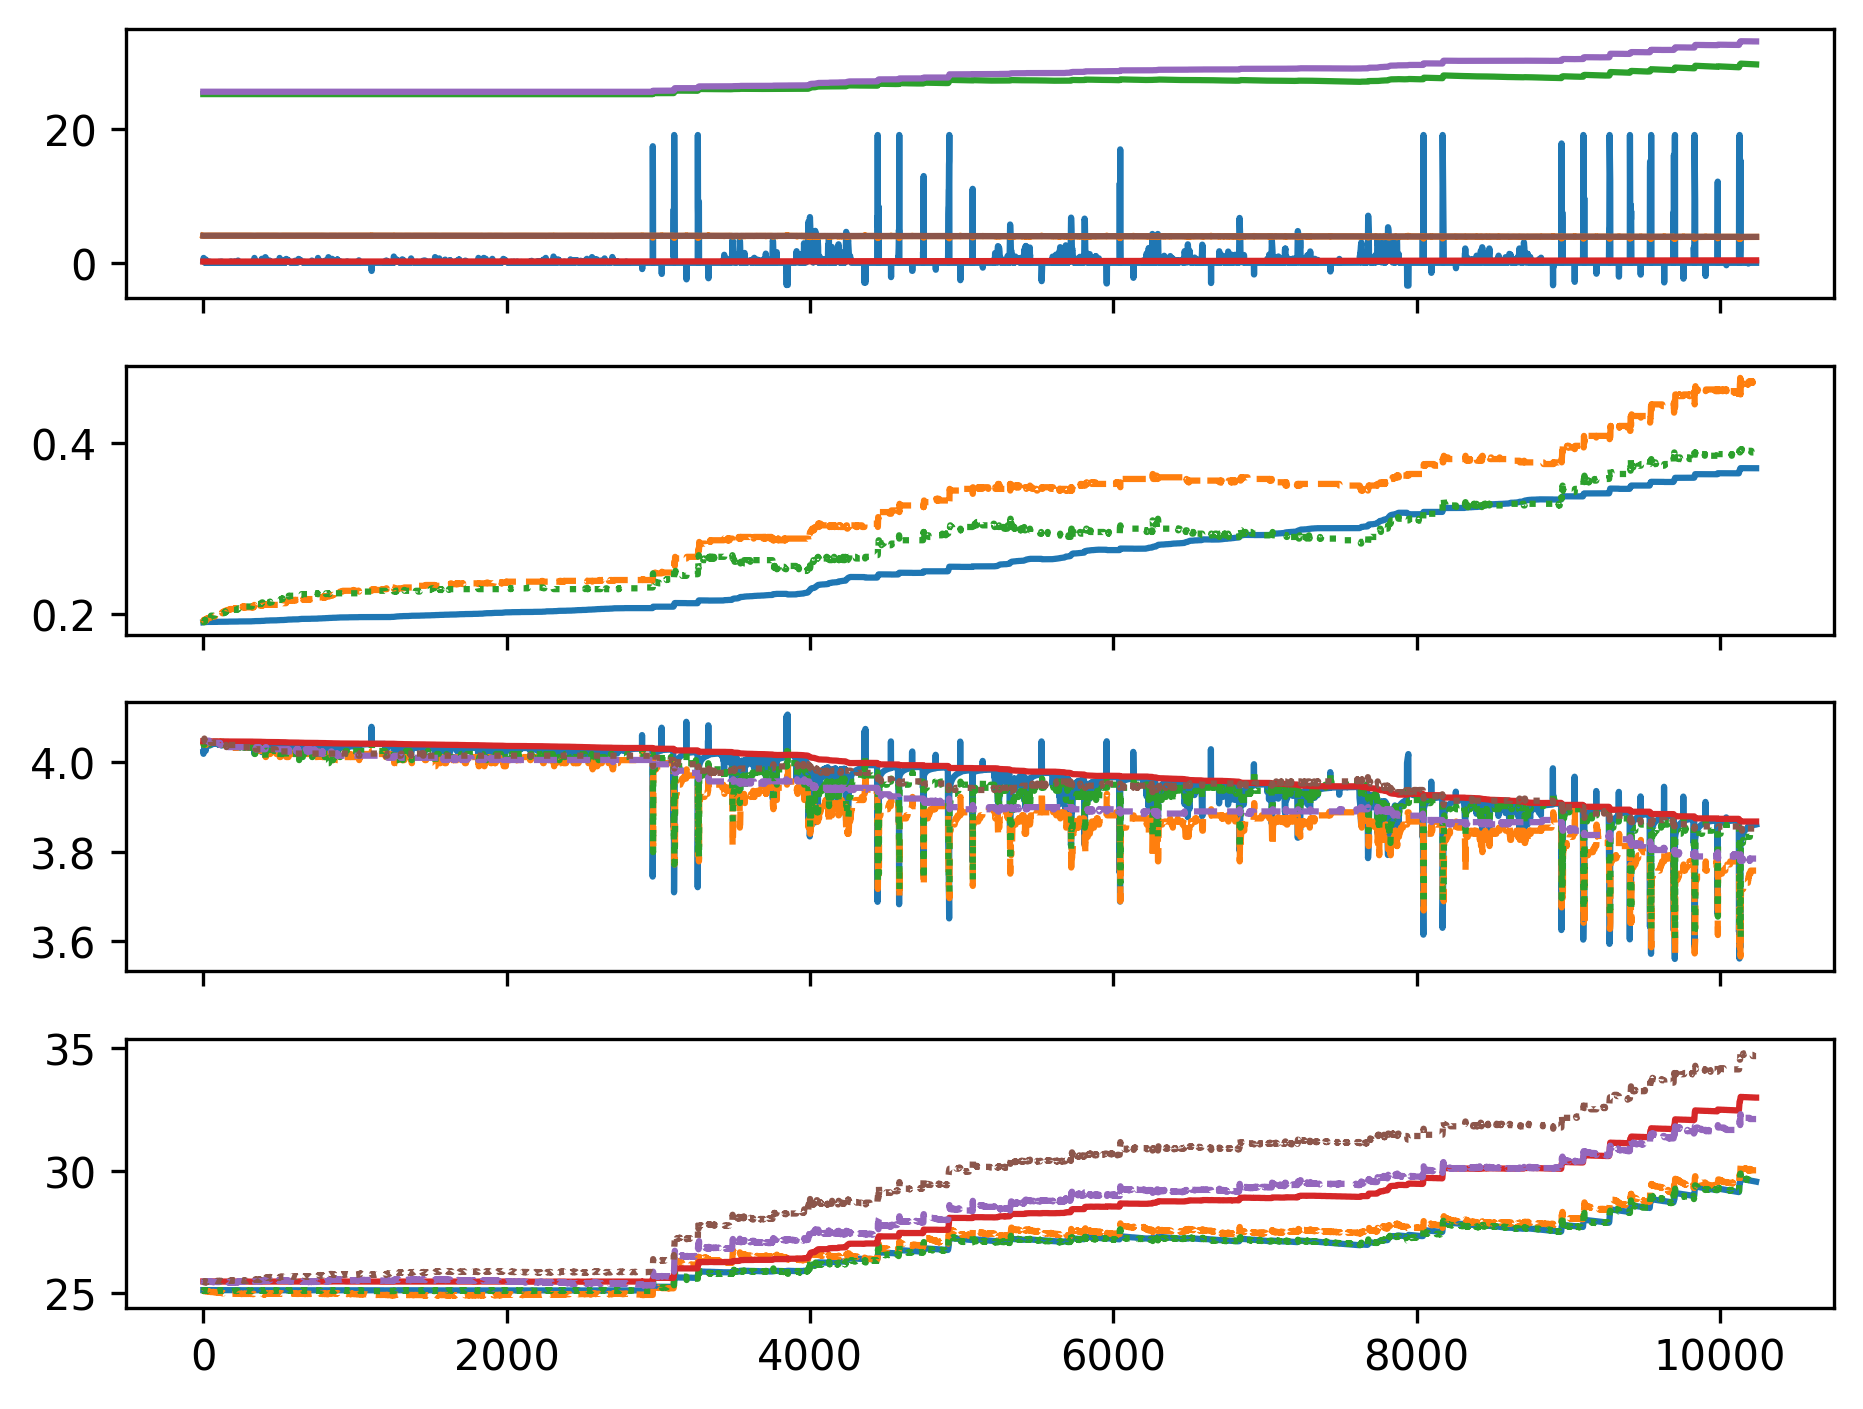

In [3]:
# transformer_trapz_Alibi
ckpt_path = "ckpt/transformer/v_58/1.4e-05_val_loss.pt"
model_args = ModelArgs(pe_type="RoPE")
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_60/1.4e-05_val_loss.pt
number of parameters: 113.26M
6437.050538406707 23353.45096206665


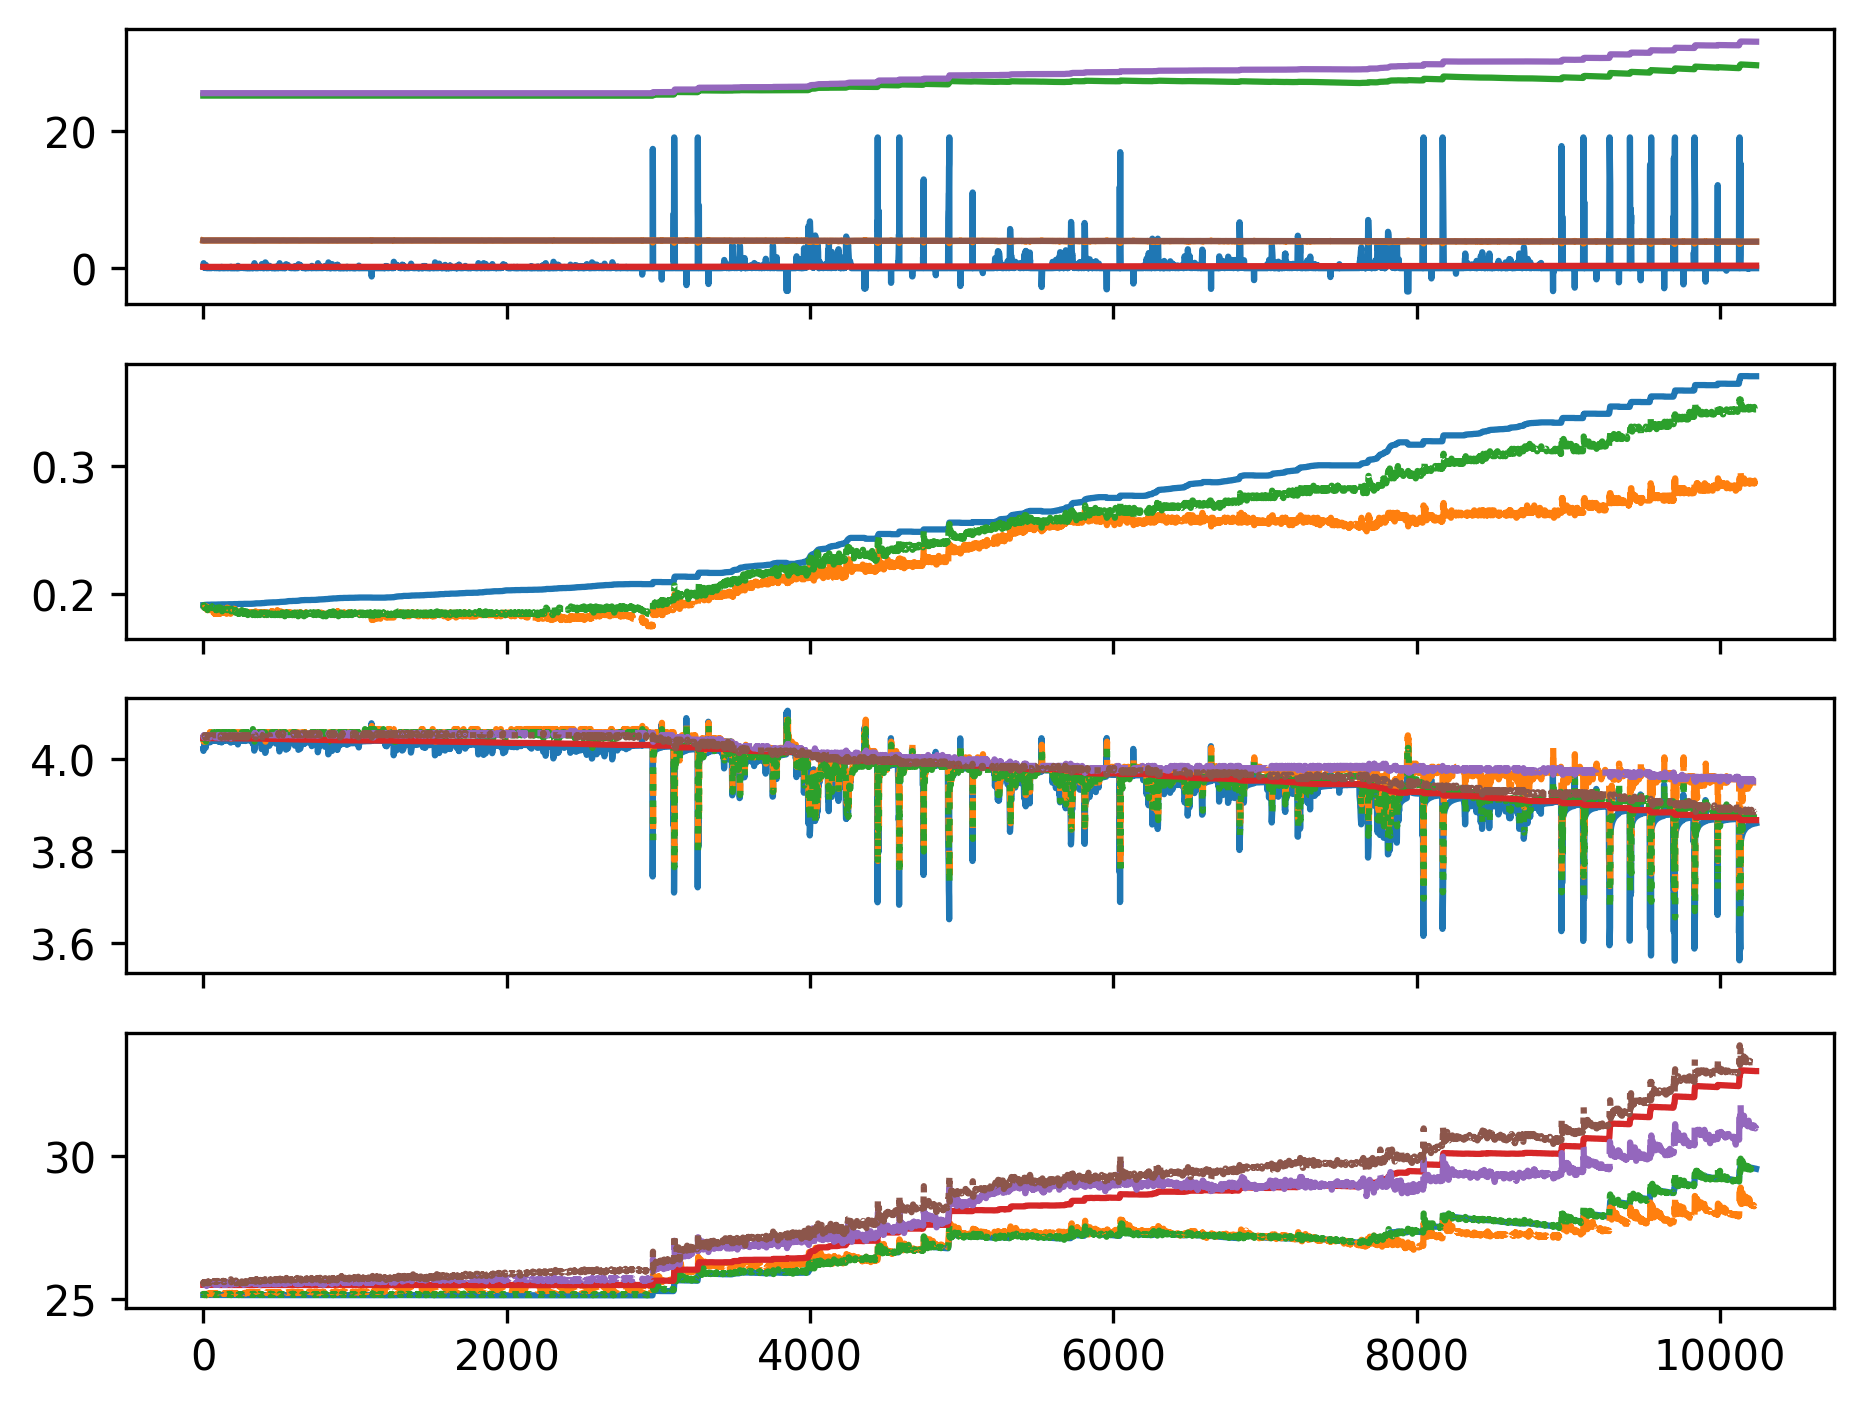

In [4]:
# transformer_trapz_48heads_113M
ckpt_path = "ckpt/transformer/v_60/1.4e-05_val_loss.pt"
model_args = ModelArgs()
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_3/1.8e-05_val_loss.pt
number of parameters: 402.69M
609608.9715828039 7741.930924357439


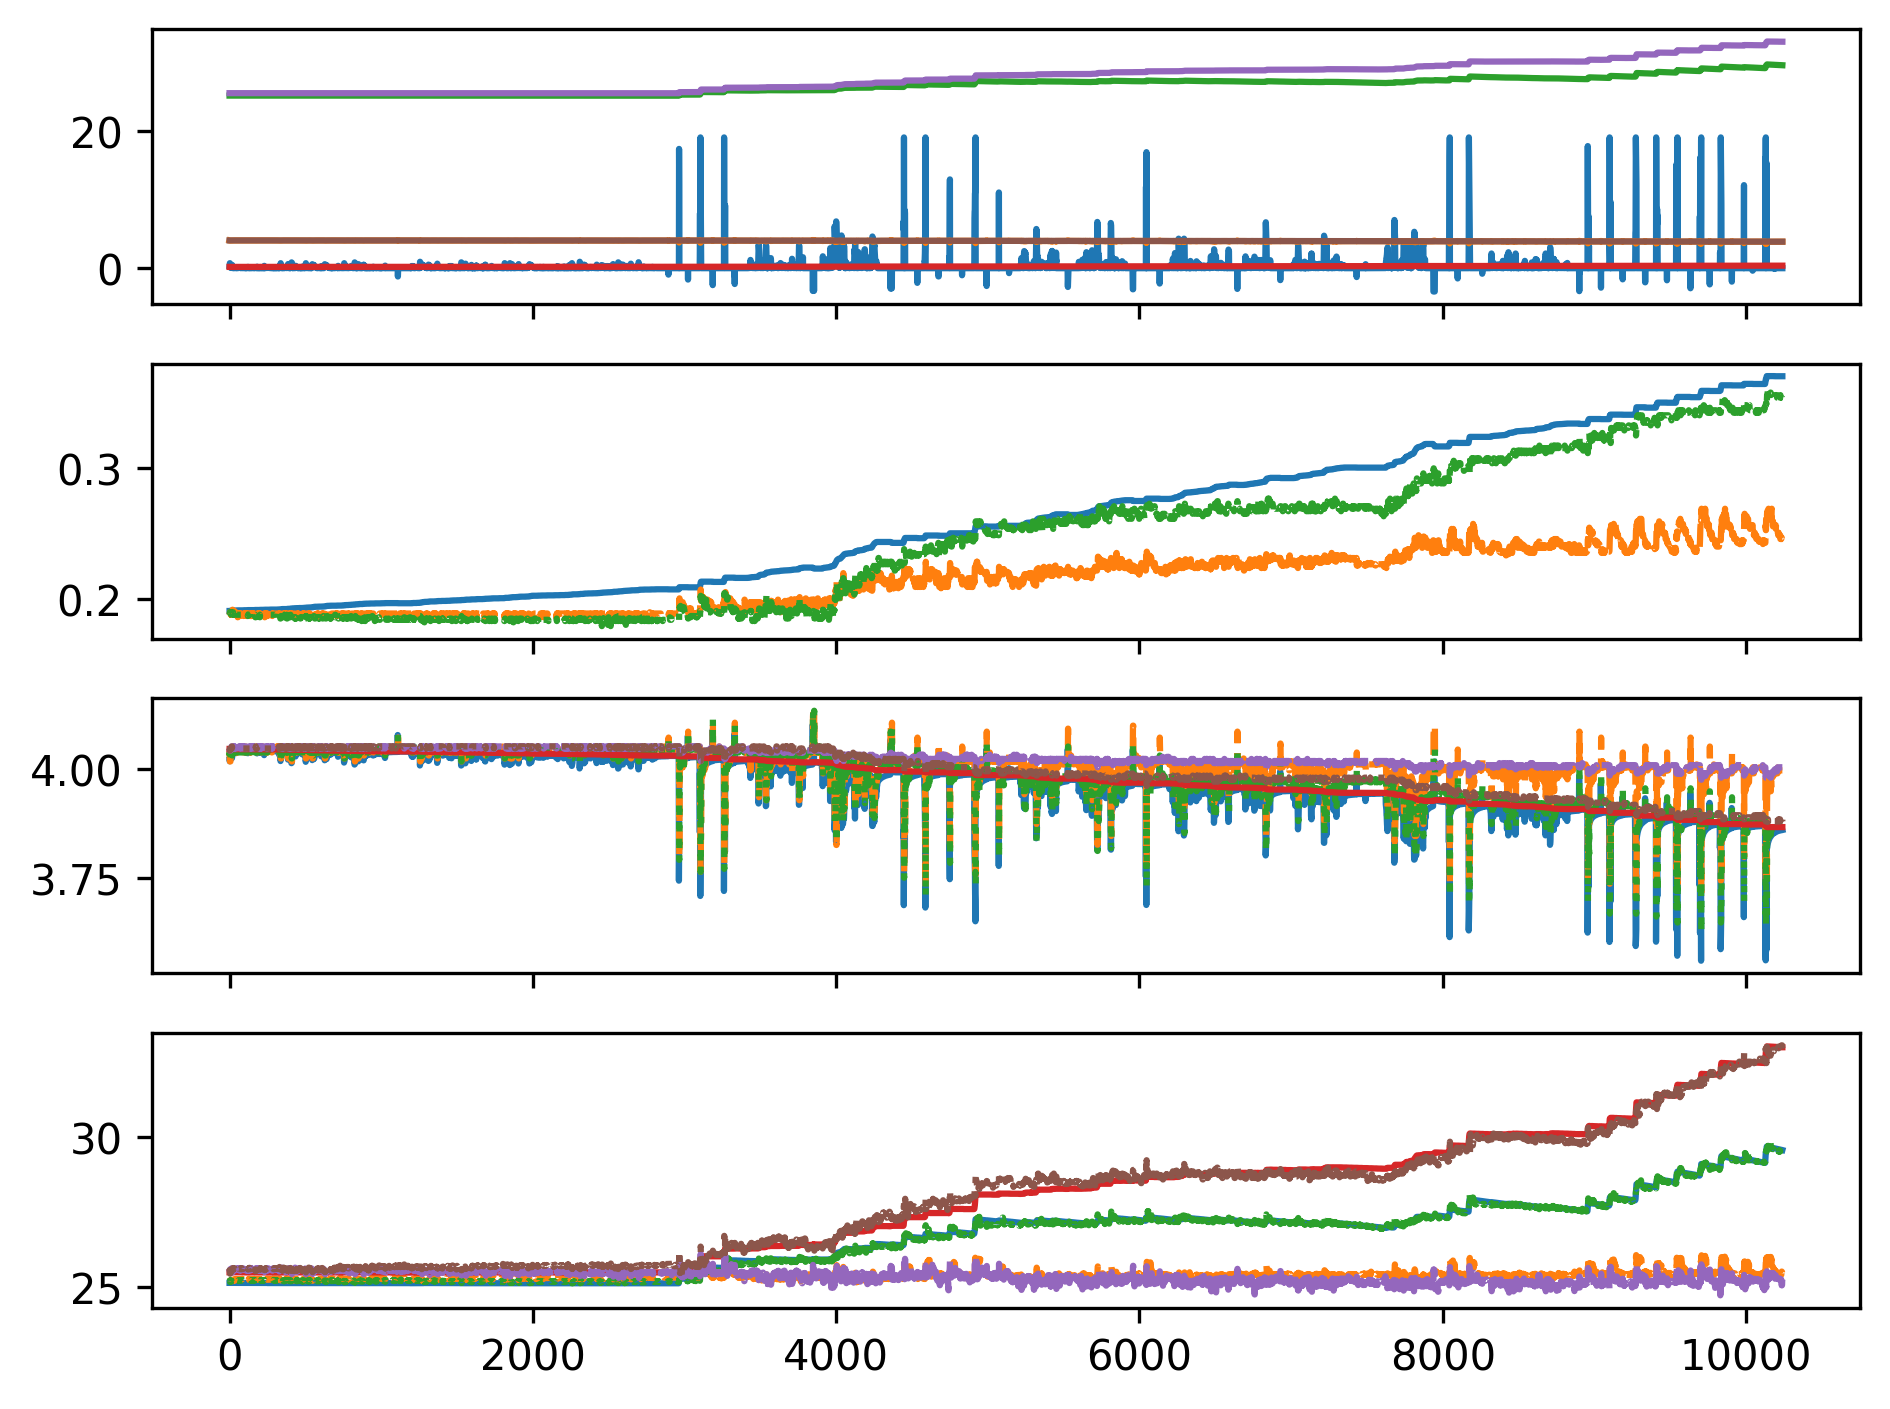

In [3]:
# transformer_trapz_max_mem_A100_80GB_GPT2_medium_400M
ckpt_path = "ckpt/transformer/v_3/1.8e-05_val_loss.pt"
model_args = ModelArgs()
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_5/8.4e-05_val_loss.pt
number of parameters: 113.26M
5164.577917959599 59199.24999727309


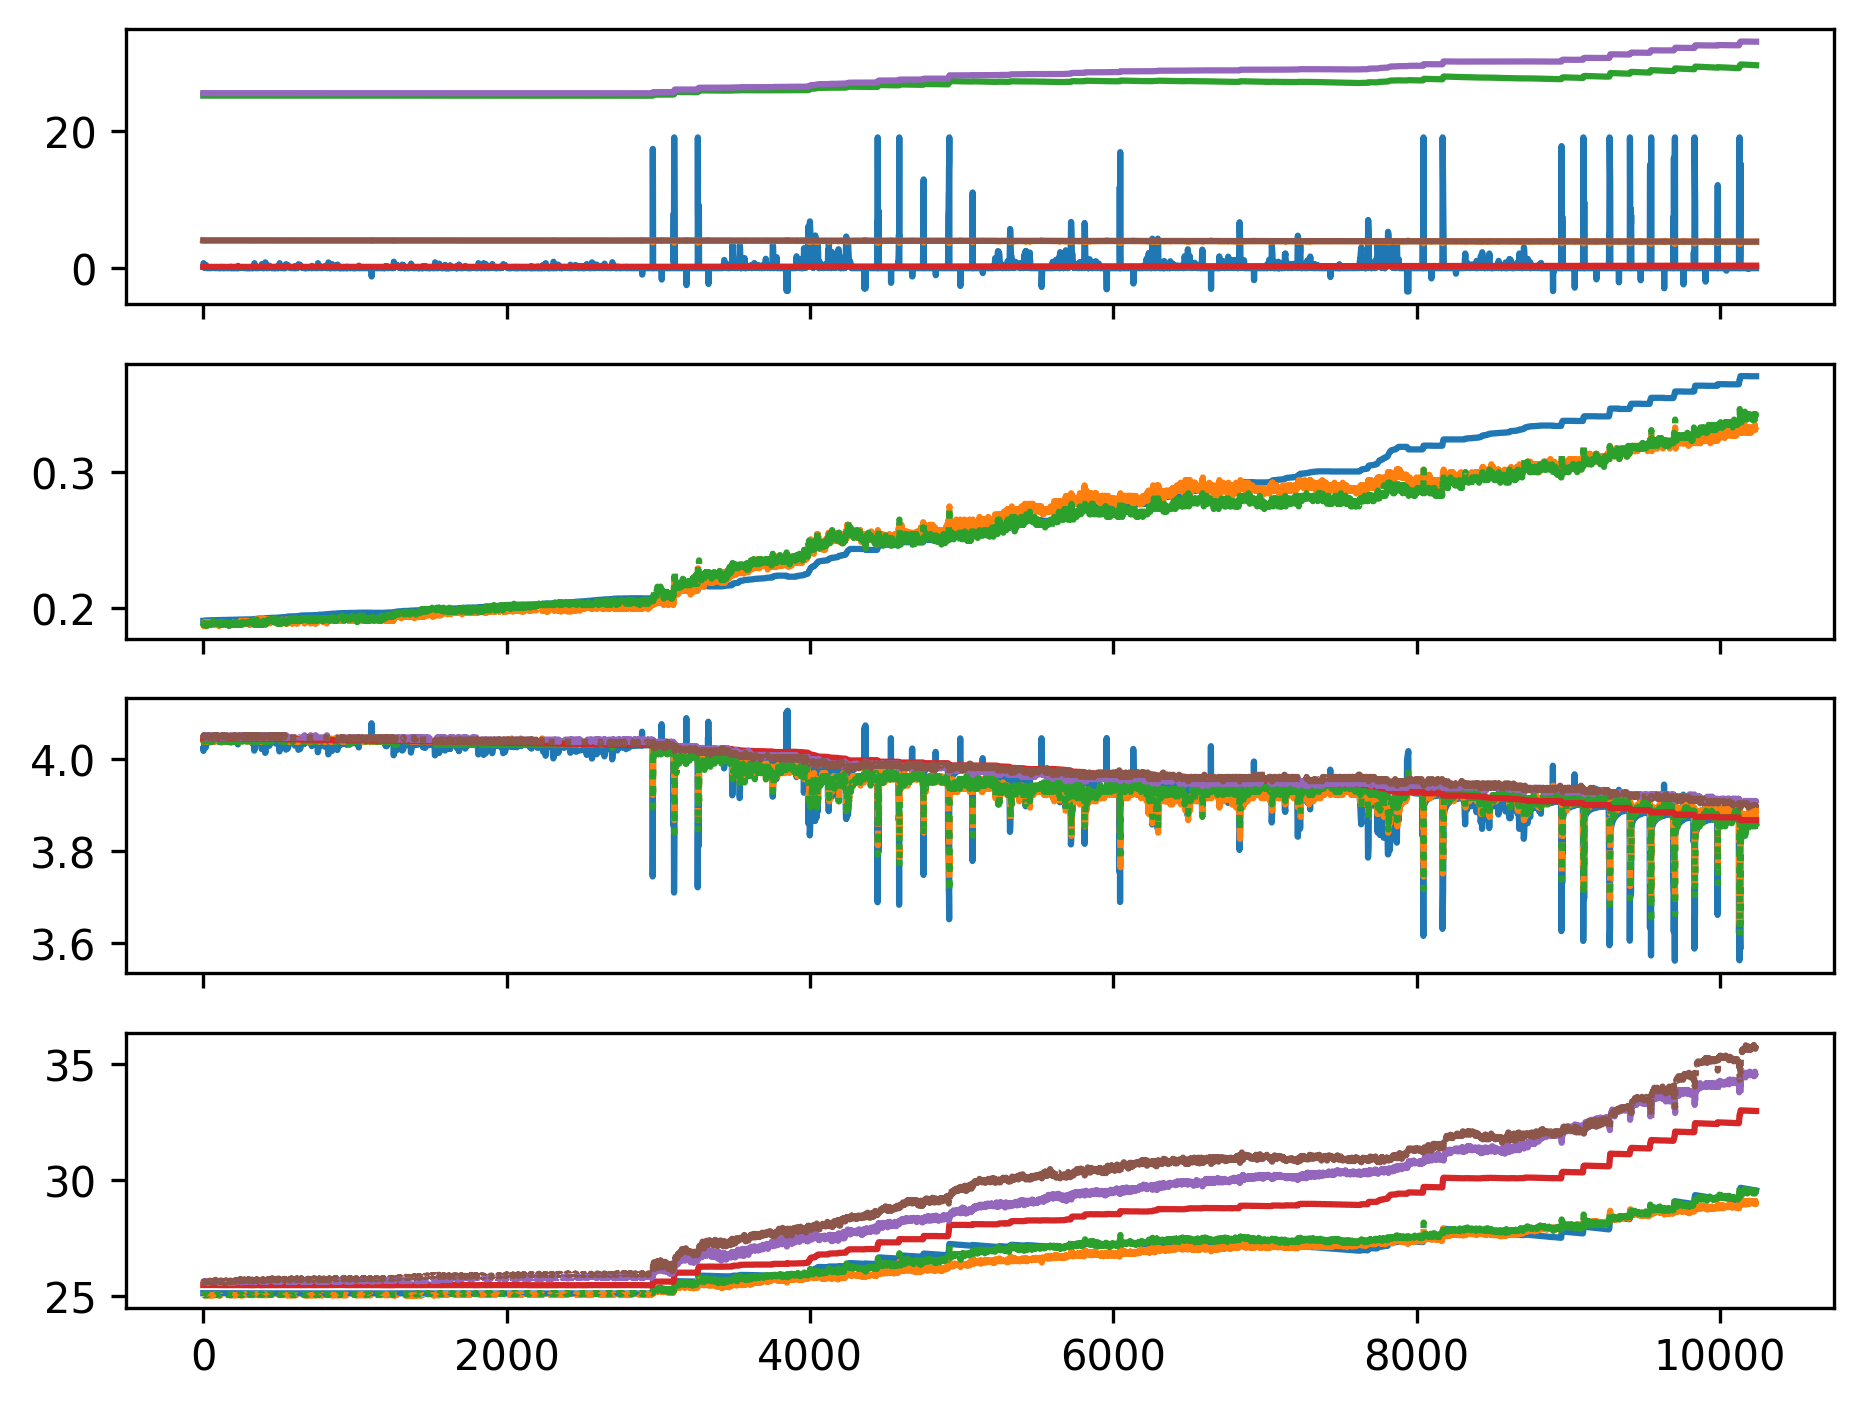

In [3]:
# transformer_trapz_192heads
ckpt_path = "ckpt/transformer/v_5/8.4e-05_val_loss.pt"
model_args = ModelArgs()
estimate_loss(ckpt_path, model_args)

Resuming training from ckpt/transformer/v_6/4.9e-06_val_loss.pt
number of parameters: 113.26M
1115485.3632964045 1365169.7419760227


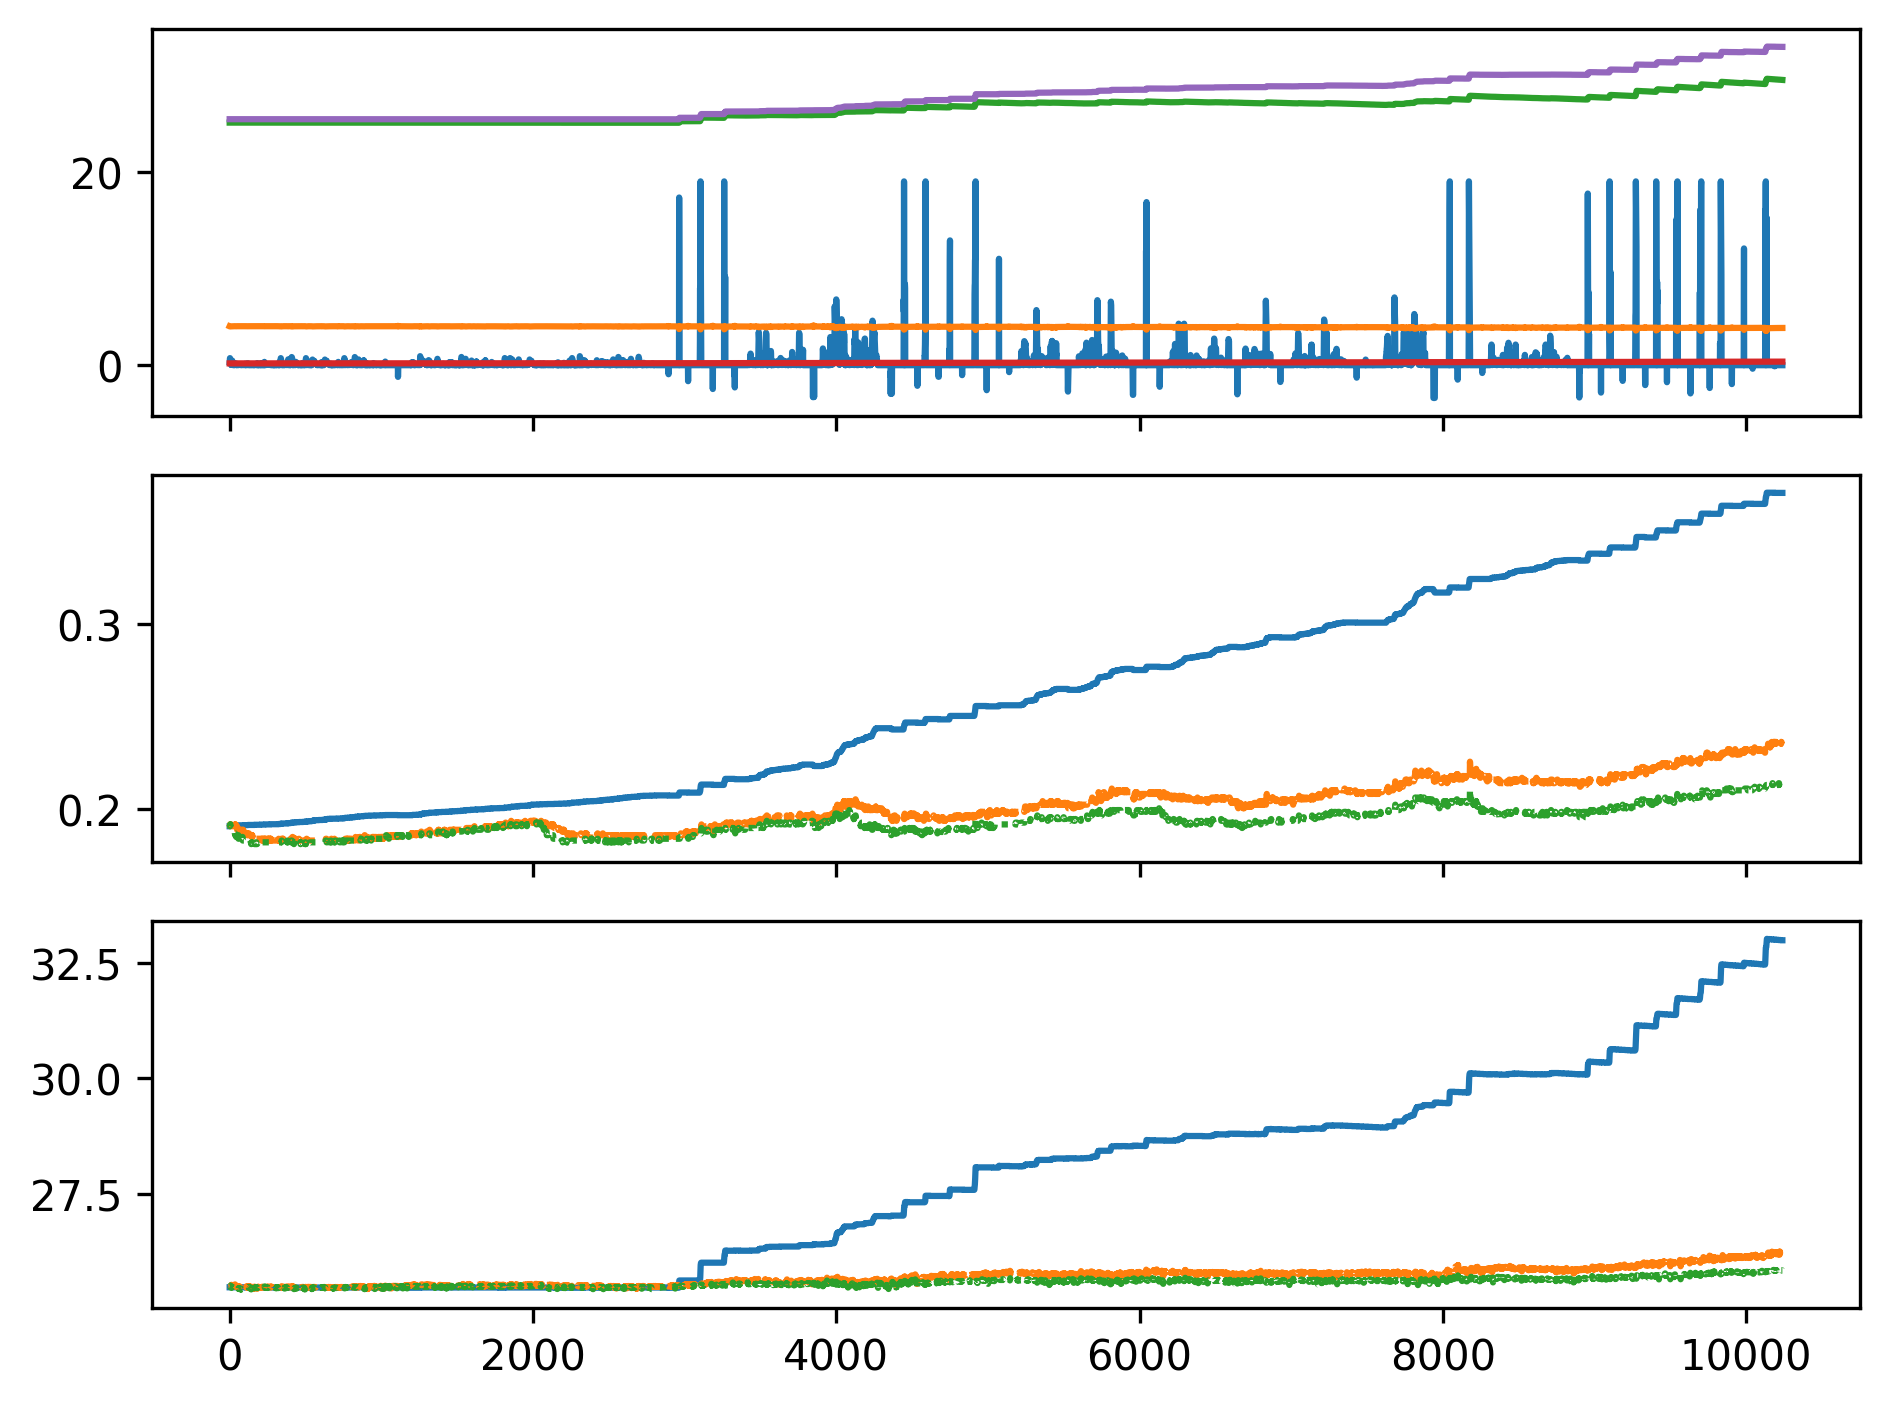

In [3]:
# transformer_trapz_SoC&T_core_only
ckpt_path = "ckpt/transformer/v_6/4.9e-06_val_loss.pt"
model_args = ModelArgs()
estimate_loss(ckpt_path, model_args)